# Vizualiation of predicitons 

## Predictions of the top performing models according the dominance analysis and scpm ranking

### Decision Tree - Top model according to the SCPM of -5.90

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Database Reading and Manipulation
import pandas as pd

# Linear Algebra
import numpy as np

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

# Modeling
from sklearn.ensemble import RandomForestRegressor

# Modeling
from sklearn.tree import DecisionTreeRegressor

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

# Processing
from sklearn.preprocessing import StandardScaler


# Pipeline
from sklearn.pipeline import Pipeline

# Data imputation
from sklearn.impute import SimpleImputer

# Custom modules
## Model selection
from src.cross_validation.blocking_time_series_split import BlockingTimeSeriesSplit

## Function to print scores
from src.utils.print_scores import print_scores

## Function to calculate score regression metrics
from src.utils.score_regression_metrics import score_regression_metrics

## Function to fill the results metric dict
from src.utils.fill_results_dict import fill_results_dict

# Warnings
import warnings

<IPython.core.display.Javascript object>

# Functions and definitions

In [3]:
def get_random_forest_df_importances(scores):
    importances = {}
    importances_with_column = []
    columns = x.columns

    for index, pipeline in enumerate(scores["estimator"]):
        model = pipeline.named_steps["estimator"]
        importances[index] = model.feature_importances_

    for index, importances_vec in importances.items():
        importances_col = pd.DataFrame(
            {col: [c] for col, c in zip(columns, importances_vec)},
            index=[f"Importances - {index}"],
        )
        importances_with_column.append(importances_col)
    df_importances = pd.concat(importances_with_column)

    return df_importances

<IPython.core.display.Javascript object>

In [4]:
SEED = 47
METRICS = (
    "neg_root_mean_squared_error",
    "neg_mean_absolute_error",
    "neg_mean_absolute_percentage_error",
    "r2",
)
METRICS_DICT = {
    "neg_root_mean_squared_error": "RMSE",
    "neg_mean_absolute_error": "MAE",
    "neg_mean_absolute_percentage_error": "MAPE",
    "r2": "R2",
}

<IPython.core.display.Javascript object>

## Defining a dataframe structure to save the results

In [5]:
results_to_save = []

results_dict = {
    "Category": "Local Model",
    "Company": "203",
    "Plant": "C",
    "Features": "Chemical",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "Random Forest",
    "Model Params": None,
    "Scaler": None,
    "Scaler Params": None,
    "Imputer": "Median",
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

# Reading the dataset

In [6]:
df = pd.read_csv("../../../../data/processed/203/c.csv")

<IPython.core.display.Javascript object>

## Defining Features

In this set of experiments we keep only chemical and mineralogical features yielded by the same testing method/procedure

In [7]:
df_copy = df.copy().drop(
    [
        "Cement_Type",
        "Blaine",
        "#200",
        "#325",
        "Final setting time",
        "Initial setting time",
        "CS1",
        "CS3",
        "CS7",
    ],
    axis=1,
)

<IPython.core.display.Javascript object>

# 1. Decision Tree Regressor

In [8]:
PARAMS = {
    "criterion": "squared_error",
    "max_depth": 3,
    "random_state": SEED,
    "splitter": "best",
}

<IPython.core.display.Javascript object>

<h2>1. Dataset: df_no_cs</h2> <br>In this dataset the CS1, CS3  and CS7 variables are not considered. Only Chemical and mineralogical features measured by the same method. For this particular dataset, all chemical features, with the exception of LOI were measured by XRF and XRD methods.

In [9]:
y = df_copy.pop("CS28").values
x = df_copy.drop(["Date"], axis=1)
dates = df["Date"].copy()

<IPython.core.display.Javascript object>

## 1.3. Time Series Split Cross Validation

In [10]:
n_splits = 5
gap = 0
repeats = 1
pipeline = Pipeline(
    [
        ("estimator", DecisionTreeRegressor(**PARAMS)),
    ]
)
cv = TimeSeriesSplit(gap=gap, max_train_size=None, n_splits=n_splits, test_size=None)

scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    return_estimator=True,
    return_indices=True,
)
print("Time Series Split:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Time Series Split"
results_dict_copy["Cross Validation Params"] = '{"N_Splits": 5, "Repeats": 1, "Gap": 0}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Time Series Split:
Repeats: 1
n_splits: 5

******
[TRAIN]
******
RMSE: -1.796 (0.448)
MAE: -1.162 (0.204)
MAPE: -0.028 (0.005)
R2: 0.903 (0.045)


******
[TEST]
******
RMSE: -2.614 (0.997)
MAE: -1.500 (0.505)
MAPE: -0.035 (0.011)
R2: 0.782 (0.151)




<IPython.core.display.Javascript object>

## Plotting the Predictions

In [11]:
# Store predictions for each fold
all_predictions = []

for idx, pipeline in enumerate(scores["estimator"]):
    index_train = scores["indices"]["train"][idx]
    index_test = scores["indices"]["test"][idx]
    index_preds = np.concatenate([index_train, index_test])

    results = pipeline.predict(x.loc[index_preds])

    # Store predictions along with fold information
    fold_predictions = pd.DataFrame(
        {
            "DATE": dates[index_preds],
            "CS28": y[index_preds],
            "CS28_PRED": results,
            "SET": ["TRAIN"] * len(index_train) + ["TEST"] * len(index_test),
            "FOLD": [idx + 1] * len(index_preds),  # Indicate the fold number
        }
    )
    all_predictions.append(fold_predictions)

# Concatenate predictions from all folds
df_pred = pd.concat(all_predictions)
df_pred["DATE"] = pd.to_datetime(df_pred["DATE"])

<IPython.core.display.Javascript object>

In [12]:
df_pred

,DATE,CS28,CS28_PRED,SET,FOLD
0,2017-08-01 15:36:00,49.03,46.739140,TRAIN,1
1,2017-08-02 15:41:00,46.93,46.739140,TRAIN,1
2,2017-08-02 15:41:00,33.20,33.884687,TRAIN,1
3,2017-08-04 15:41:00,46.80,46.739140,TRAIN,1
4,2017-08-04 15:41:00,34.40,35.555000,TRAIN,1
...,...,...,...,...,...
2824,2023-03-28 11:01:00,47.19,47.144311,TEST,5
2825,2023-03-29 11:01:00,33.78,34.537182,TEST,5
2826,2023-03-29 11:01:00,46.58,47.144311,TEST,5
2827,2023-03-29 11:01:00,46.28,47.144311,TEST,5


<IPython.core.display.Javascript object>

In [13]:
(df_pred["SET"] == "TEST").sum()

2355

<IPython.core.display.Javascript object>

In [14]:
matplotlib.rc_file_defaults()

<IPython.core.display.Javascript object>

In [15]:
df[["CS28"]].describe().T

,count,mean,std,min,25%,50%,75%,max
CS28,2829.0,43.732124,5.959211,31.53,36.25,46.55,47.83,52.35


<IPython.core.display.Javascript object>

In [16]:
# Store predictions for each fold
all_predictions = []

for idx, pipeline in enumerate(scores["estimator"]):
    index_train = scores["indices"]["train"][idx]
    index_test = scores["indices"]["test"][idx]
    index_preds = np.concatenate([index_train, index_test])

    results = pipeline.predict(x.loc[index_preds])

    # Store predictions along with fold information
    fold_predictions = pd.DataFrame(
        {
            "DATE": dates[index_preds],
            "CS28": y[index_preds],
            "CS28_PRED": results,
            "SET": ["TRAIN"] * len(index_train) + ["TEST"] * len(index_test),
            "FOLD": [idx + 1] * len(index_preds),  # Indicate the fold number
        }
    )
    all_predictions.append(fold_predictions)

# Concatenate predictions from all folds
df_pred = pd.concat(all_predictions)
df_pred["DATE"] = pd.to_datetime(df_pred["DATE"])

<IPython.core.display.Javascript object>

In [17]:
# df_copy_merge = df_copy.merge(df_pred, left_index=True, right_index=True, how="left")
# df_copy_merge["COMPANY"] = 209
# df_copy_merge["PLANT"] = "S"
# for fold, (train_index, test_index) in enumerate(cv.split(x)):
#     df_copy_merge.loc[train_index, "FOLD"] = fold + 1
#     df_copy_merge.loc[test_index, "FOLD"] = fold + 1
# df_copy_merge["FOLD"] = df_copy_merge["FOLD"].astype(int)
# df_copy_merge.to_excel("local_model_decision_tree_tsscv_203_s.xlsx", index=False)
# df_copy_merge.to_csv("local_model_decision_tree_tsscv_203_s.csv", index=False)

<IPython.core.display.Javascript object>

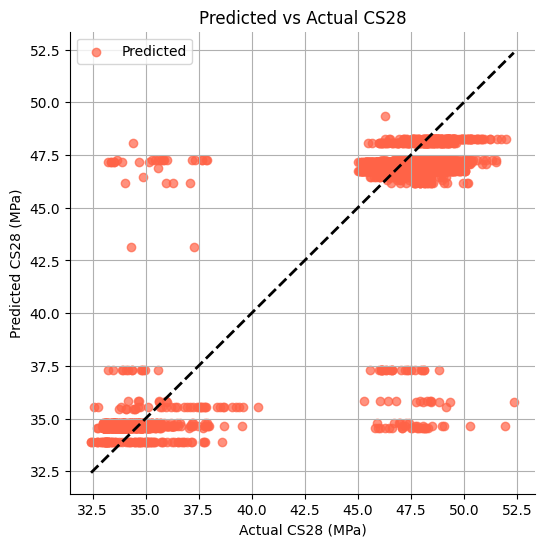

<IPython.core.display.Javascript object>

In [18]:
# Scatter plot of actual vs predicted values
test_data = df_pred[df_pred["SET"] == "TEST"]
plt.figure(figsize=(6, 6))
plt.scatter(
    test_data["CS28"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    label="Predicted",
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    color="black",
    linestyle="--",
    linewidth=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "ecics_203_c_local_cm_tiss_scpm_top_one_scpm_pred_vs_actual_cs28.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

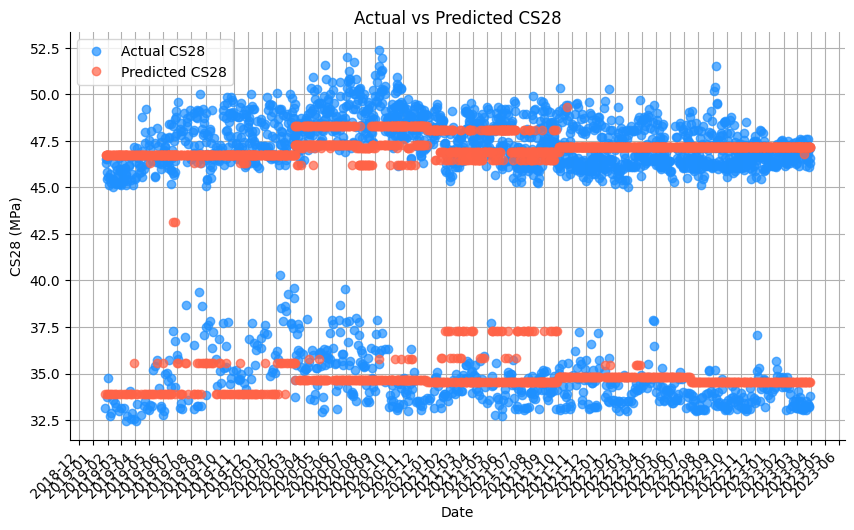

<IPython.core.display.Javascript object>

In [19]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(10, 6))
plt.plot(
    test_data["DATE"],
    test_data["CS28"],
    color="dodgerblue",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Actual CS28",
)
plt.plot(
    test_data["DATE"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Predicted CS28",
)
plt.xlabel("Date")
plt.ylabel("CS28 (MPa)")
plt.title("Actual vs Predicted CS28")
plt.legend()
plt.grid(True)

# Improving x-axis readability
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Set ticks for each month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format date as 'YYYY-MM-DD'
plt.gcf().autofmt_xdate(rotation=45)  # Rotate x-axis labels

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "ecics_203_c_local_cm_tiss_scpm_top_one_scpm_pred_vs_actual_cs28_over_time.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


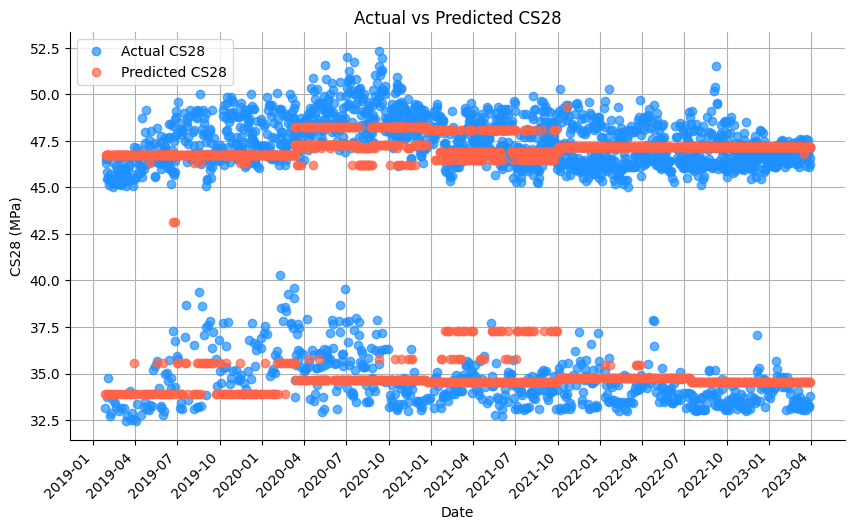

<IPython.core.display.Javascript object>

In [20]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(10, 6))
plt.plot(
    test_data["DATE"],
    test_data["CS28"],
    color="dodgerblue",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Actual CS28",
)
plt.plot(
    test_data["DATE"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Predicted CS28",
)
plt.xlabel("Date")
plt.ylabel("CS28 (MPa)")
plt.title("Actual vs Predicted CS28")
plt.legend()
plt.grid(True)

# Improved x-axis readability
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Display every 3rd month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format date as 'YYYY-MM'
plt.gcf().autofmt_xdate(rotation=45)  # Rotate x-axis labels for clarity

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "ecics_203_c_local_cm_tiss_scpm_top_one_scpm_pred_vs_actual_cs28_over_time.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


## Assessing Feature Importance

In [21]:
df_importances = get_random_forest_df_importances(scores)

<IPython.core.display.Javascript object>

In [22]:
df_importances

,CaO,MgO,Na2O,Al2O3,SiO2,SO3,K2O,TiO2,Fe2O3,Loss on Ignition,Insoluble Residue
Importances - 0,23.262725,0.000000,NaN,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,30.975548
Importances - 1,NaN,0.156443,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.065985,0.000000
Importances - 2,0.641502,0.005727,0.0,0.0,0.005846,0.020397,0.0,0.0,0.326528,0.000000,0.000000
Importances - 3,22.528977,0.000000,0.0,NaN,24.508571,0.393284,0.0,0.0,0.000000,0.000000,0.000000
Importances - 4,0.229994,0.000000,0.0,0.0,0.486044,0.283962,0.0,0.0,0.000000,0.000000,0.000000


<IPython.core.display.Javascript object>

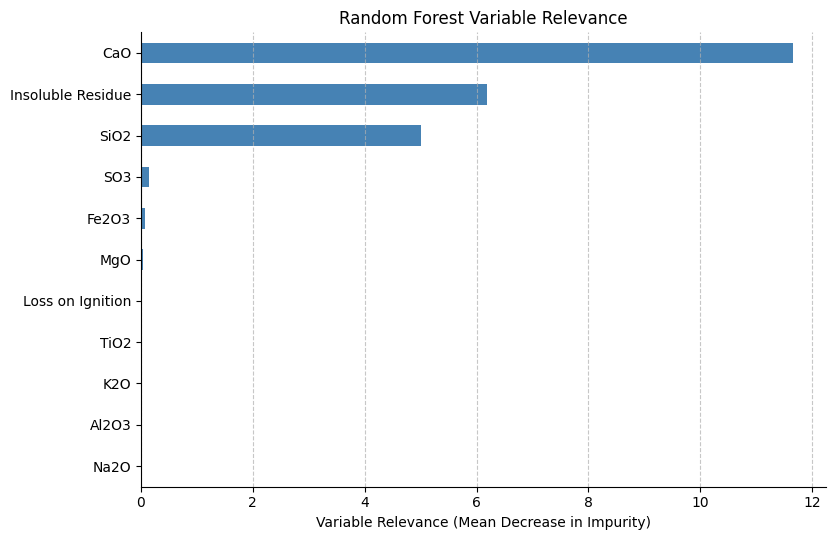

<IPython.core.display.Javascript object>

In [23]:
df_importances.mean(axis=0).sort_values().plot(
    kind="barh", figsize=(10, 5.5), color="steelblue"  # Consider using 'steelblue'
)
plt.title("Random Forest Variable Relevance")
plt.xlabel("Variable Relevance (Mean Decrease in Impurity)")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
plt.subplots_adjust(left=0.3)
plt.show()

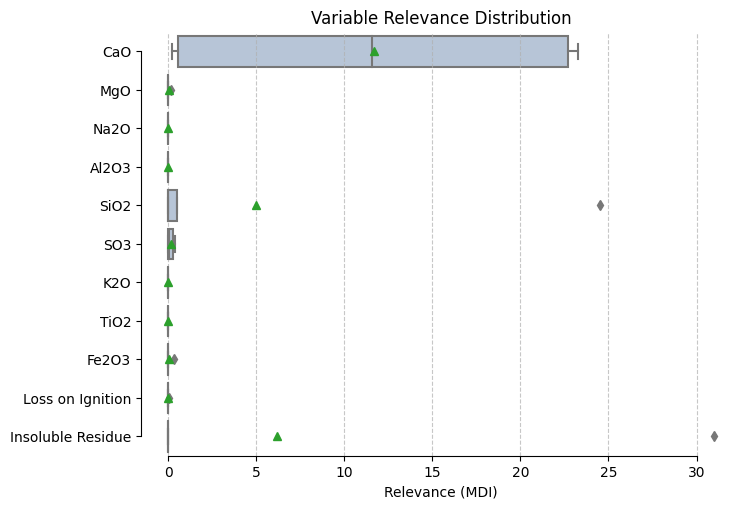

<IPython.core.display.Javascript object>

In [24]:
warnings.filterwarnings("ignore")
plt.figure(figsize=(10, 5.5))
sns.boxplot(data=df_importances, orient="h", color="lightsteelblue", saturation=0.7, showmeans=True)
sns.despine(trim=True, left=False)
plt.xlabel("Relevance (MDI)")
plt.title("Variable Relevance Distribution")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.show()


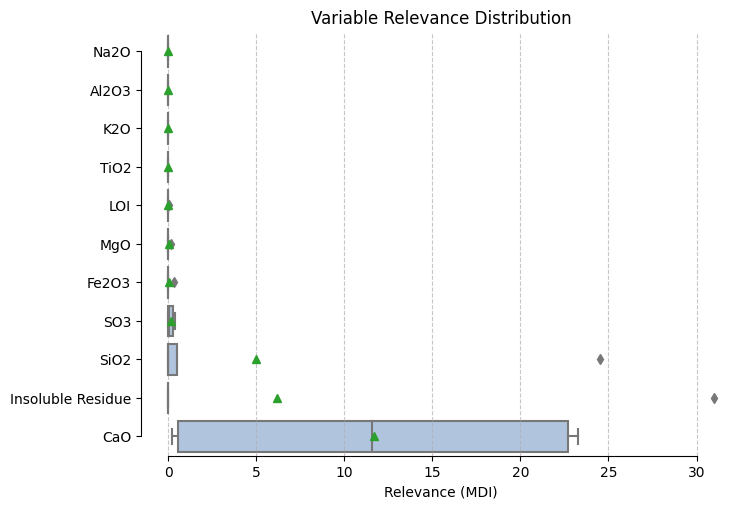

<IPython.core.display.Javascript object>

In [25]:
# Calculate the means of the importance scores
mean_importances = df_importances.mean()

# Sort the features by their mean relevance
sorted_features = mean_importances.sort_values()

# Re-order the DataFrame according to the sorted features
df_importances_sorted = df_importances[sorted_features.index]

# Plot the sorted boxplot
df_importances_sorted = df_importances_sorted.rename(
    columns={"Loss on Ignition": "LOI"}
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=df_importances_sorted,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Relevance (MDI)")
plt.title("Variable Relevance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_203_c_local_cm_tiss_decision_tree_scpm_best_dist_var_relevance.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

In [26]:
print("Default font family:", matplotlib.rcParams["font.family"])
print("Default sans-serif fonts:", matplotlib.rcParams["font.sans-serif"])
print("Default font size:", matplotlib.rcParams["font.size"])
print("Default font weight:", matplotlib.rcParams["font.weight"])

Default font family: ['sans-serif']
Default sans-serif fonts: ['DejaVu Sans', 'Bitstream Vera Sans', 'Computer Modern Sans Serif', 'Lucida Grande', 'Verdana', 'Geneva', 'Lucid', 'Arial', 'Helvetica', 'Avant Garde', 'sans-serif']
Default font size: 10.0
Default font weight: normal


<IPython.core.display.Javascript object>

In [27]:
plt.get_backend()

'module://matplotlib_inline.backend_inline'

<IPython.core.display.Javascript object>

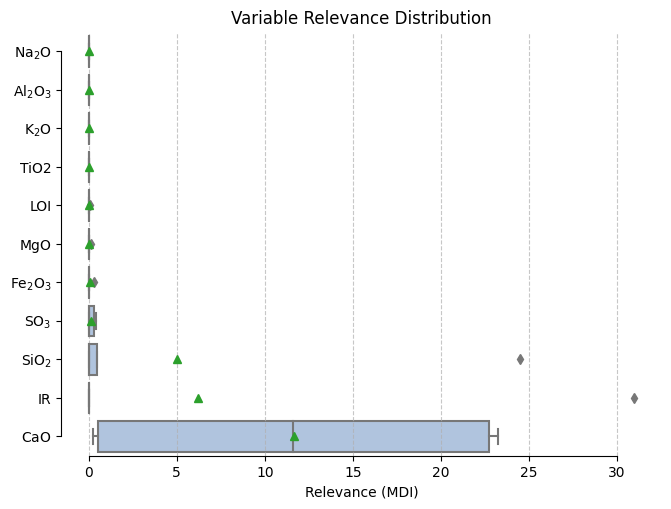

<IPython.core.display.Javascript object>

In [28]:
# Backup the original backend
original_backend = plt.get_backend()

# Use Matplotlib's default backend
# plt.switch_backend("agg")  # or any backend you prefer

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)

# plt.rcParams.update(
#     {
#         "mathtext.fontset": "custom",
#         "mathtext.rm": "DejaVu Sans",
#         "mathtext.it": "DejaVu Sans:italic",
#         "mathtext.bf": "DejaVu Sans:bold",
#     }
# )


# Convert chemical formulas using MathText syntax
df_importances_sorted_plot = df_importances_sorted.rename(
    columns={
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
    }
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=df_importances_sorted_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Relevance (MDI)")
plt.title("Variable Relevance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_203_c_local_cm_tiss_decision_tree_scpm_best_dist_var_relevance.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()


# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

In [29]:
df_importances

,CaO,MgO,Na2O,Al2O3,SiO2,SO3,K2O,TiO2,Fe2O3,Loss on Ignition,Insoluble Residue
Importances - 0,23.262725,0.000000,NaN,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,30.975548
Importances - 1,NaN,0.156443,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.065985,0.000000
Importances - 2,0.641502,0.005727,0.0,0.0,0.005846,0.020397,0.0,0.0,0.326528,0.000000,0.000000
Importances - 3,22.528977,0.000000,0.0,NaN,24.508571,0.393284,0.0,0.0,0.000000,0.000000,0.000000
Importances - 4,0.229994,0.000000,0.0,0.0,0.486044,0.283962,0.0,0.0,0.000000,0.000000,0.000000


<IPython.core.display.Javascript object>

In [30]:
df_importances.describe().T

,count,mean,std,min,25%,50%,75%,max
CaO,4.0,11.665799,12.971894,0.229994,0.538625,11.585239,22.712414,23.262725
MgO,5.0,0.032434,0.069367,0.000000,0.000000,0.000000,0.005727,0.156443
Na2O,4.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Al2O3,4.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SiO2,5.0,5.000092,10.907586,0.000000,0.000000,0.005846,0.486044,24.508571
SO3,5.0,0.139529,0.185999,0.000000,0.000000,0.020397,0.283962,0.393284
K2O,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TiO2,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Fe2O3,5.0,0.065306,0.146028,0.000000,0.000000,0.000000,0.000000,0.326528
Loss on Ignition,5.0,0.013197,0.029510,0.000000,0.000000,0.000000,0.000000,0.065985


<IPython.core.display.Javascript object>

In [31]:
df_importances.mean(axis=0)

CaO                  11.665799
MgO                   0.032434
Na2O                  0.000000
Al2O3                 0.000000
SiO2                  5.000092
SO3                   0.139529
K2O                   0.000000
TiO2                  0.000000
Fe2O3                 0.065306
Loss on Ignition      0.013197
Insoluble Residue     6.195110
dtype: float64

<IPython.core.display.Javascript object>

In [32]:
df_importances.std(axis=0)

CaO                  12.971894
MgO                   0.069367
Na2O                  0.000000
Al2O3                 0.000000
SiO2                 10.907586
SO3                   0.185999
K2O                   0.000000
TiO2                  0.000000
Fe2O3                 0.146028
Loss on Ignition      0.029510
Insoluble Residue    13.852686
dtype: float64

<IPython.core.display.Javascript object>

In [33]:
df_importances.std(axis=0, ddof=0)

CaO                  11.233990
MgO                   0.062044
Na2O                  0.000000
Al2O3                 0.000000
SiO2                  9.756041
SO3                   0.166362
K2O                   0.000000
TiO2                  0.000000
Fe2O3                 0.130611
Loss on Ignition      0.026394
Insoluble Residue    12.390219
dtype: float64

<IPython.core.display.Javascript object>

In [34]:
df_copy.nunique()

Date                 1515
CaO                   973
MgO                   326
Na2O                   48
Al2O3                 315
SiO2                  850
SO3                   235
K2O                   109
TiO2                   41
Fe2O3                 186
Loss on Ignition      494
Insoluble Residue     294
dtype: int64

<IPython.core.display.Javascript object>

In [35]:
pipeline.named_steps

{'estimator': DecisionTreeRegressor(max_depth=3, random_state=47)}

<IPython.core.display.Javascript object>

In [36]:
from sklearn.inspection import permutation_importance

<IPython.core.display.Javascript object>

In [37]:
# Initialize lists to store importance results
mdi_importances = []
perm_importances = []

# Compute feature importances
for i, (train_idx, test_idx) in enumerate(cv.split(x, y)):
    pipeline.fit(x.iloc[train_idx], y[train_idx])

    # Extract the trained model
    model = pipeline.named_steps["estimator"]

    # Compute MDI importance
    mdi_importances.append(model.feature_importances_)

    # Compute permutation importance
    result = permutation_importance(
        model,
        x.iloc[test_idx],
        y[test_idx],
        n_repeats=10,
        random_state=SEED,
        n_jobs=-1,
        # scoring="neg_mean_squared_error",
        scoring="r2",
    )
    perm_importances.append(result.importances_mean)

<IPython.core.display.Javascript object>

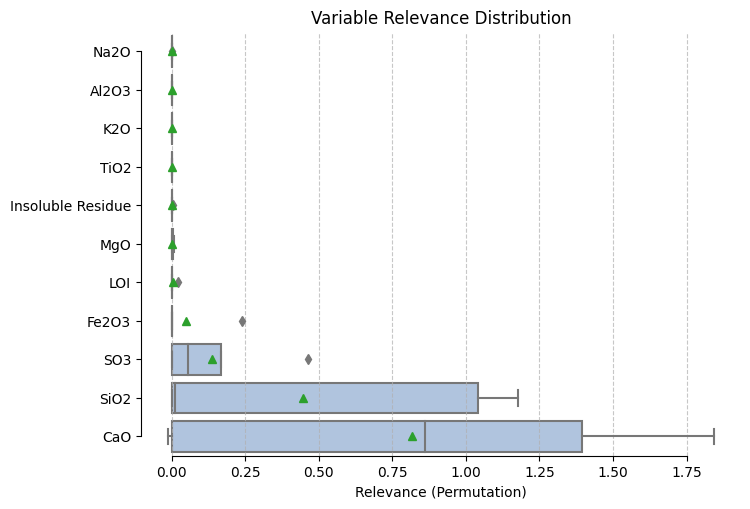

<IPython.core.display.Javascript object>

In [38]:
# Convert lists to DataFrames
mdi_importances_df = pd.DataFrame(mdi_importances, columns=x.columns)
perm_importances_df = pd.DataFrame(perm_importances, columns=x.columns)


# Calculate the mean importance for each feature
mean_importances = perm_importances_df.mean().sort_values()

# Reorder the DataFrame columns based on mean importance
perm_importances_df = perm_importances_df[mean_importances.index]

perm_importances_df = perm_importances_df.rename(columns={"Loss on Ignition": "LOI"})


plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=perm_importances_df,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Relevance (Permutation)")
plt.title("Variable Relevance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_203_c_local_cm_tiss_decision_tree_scpm_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)

# # Step 3: Reset all rcParams to their default values
plt.rcdefaults()

plt.show()

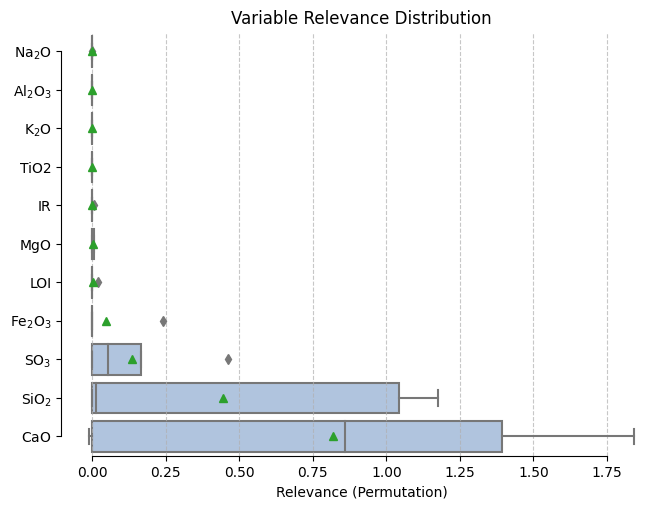

<IPython.core.display.Javascript object>

In [39]:
# Backup the original backend
original_backend = plt.get_backend()

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)

# Convert chemical formulas using MathText syntax
perm_importances_df_plot = perm_importances_df.rename(
    columns={
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
    }
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=perm_importances_df_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Relevance (Permutation)")
plt.title("Variable Relevance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_203_c_local_cm_tiss_decision_tree_scpm_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)


# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

plt.show()

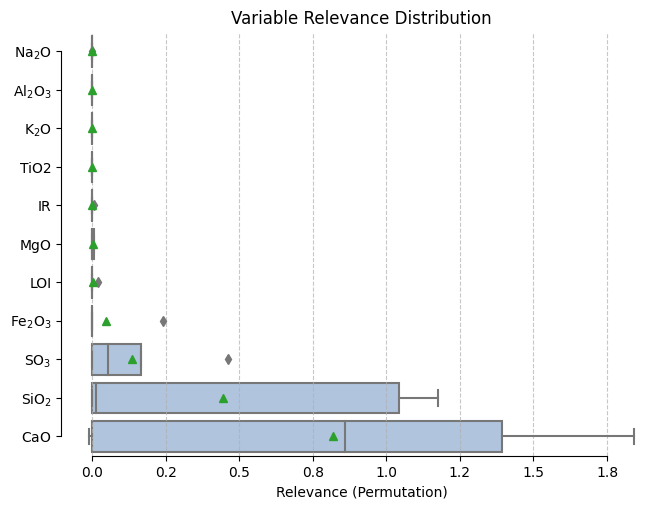

<IPython.core.display.Javascript object>

In [40]:
import matplotlib.ticker as mticker

# Step 1: Define a function to format the x-axis to one decimal place
def one_decimal(x, pos):
    return f'{x:.1f}'

# Backup the original backend
original_backend = plt.get_backend()

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)

# Convert chemical formulas using MathText syntax
perm_importances_df_plot = perm_importances_df.rename(
    columns={
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR"
    }
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=perm_importances_df_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Relevance (Permutation)")
plt.title("Variable Relevance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)

# Step 2: Apply the formatter to the x-axis
ax = plt.gca()  # Get the current axis
ax.xaxis.set_major_formatter(mticker.FuncFormatter(one_decimal))

plt.savefig(
    "ecics_203_c_local_cm_tiss_decision_tree_scpm_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)

# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

plt.show()


In [41]:
perm_importances_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Na2O,5.0,-0.000017,0.000038,-0.000085,0.000000,0.000000,0.000000,0.000000
Al2O3,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
K2O,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TiO2,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Insoluble Residue,5.0,0.001223,0.002734,0.000000,0.000000,0.000000,0.000000,0.006113
MgO,5.0,0.002423,0.003369,0.000000,0.000000,0.000000,0.005224,0.006889
LOI,5.0,0.004215,0.009426,0.000000,0.000000,0.000000,0.000000,0.021077
Fe2O3,5.0,0.048120,0.107600,0.000000,0.000000,0.000000,0.000000,0.240602
SO3,5.0,0.136862,0.194864,0.000000,0.000000,0.053931,0.166958,0.463423
SiO2,5.0,0.446247,0.607225,0.000000,0.000000,0.012583,1.041478,1.177172


<IPython.core.display.Javascript object>

In [42]:
perm_importances_df

,Na2O,Al2O3,K2O,TiO2,Insoluble Residue,MgO,LOI,Fe2O3,SO3,SiO2,CaO
0,-0.000085,0.0,0.0,0.0,0.006113,0.000000,0.000000,0.000000,0.000000,0.000000,1.841983
1,0.000000,0.0,0.0,0.0,0.000000,0.006889,0.021077,0.000000,0.000000,0.000000,1.394181
2,0.000000,0.0,0.0,0.0,0.000000,0.005224,0.000000,0.240602,0.166958,0.012583,0.861003
3,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.053931,1.041478,-0.011584
4,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.463423,1.177172,0.000606


<IPython.core.display.Javascript object>

In [43]:
perm_importances_df.mean(axis=0)

Na2O                -0.000017
Al2O3                0.000000
K2O                  0.000000
TiO2                 0.000000
Insoluble Residue    0.001223
MgO                  0.002423
LOI                  0.004215
Fe2O3                0.048120
SO3                  0.136862
SiO2                 0.446247
CaO                  0.817238
dtype: float64

<IPython.core.display.Javascript object>

In [44]:
perm_importances_df.std(axis=0, ddof=0)

Na2O                 0.000034
Al2O3                0.000000
K2O                  0.000000
TiO2                 0.000000
Insoluble Residue    0.002445
MgO                  0.003014
LOI                  0.008431
Fe2O3                0.096241
SO3                  0.174292
SiO2                 0.543118
CaO                  0.740097
dtype: float64

<IPython.core.display.Javascript object>

# Top one dominant model - Random Forest - SCPM: -5.75 | dominance counts: 117

In [45]:
PARAMS = {
    "criterion": "squared_error",
    "n_estimators": 5,
    "max_depth": 3,
    "random_state": SEED,
}

<IPython.core.display.Javascript object>

In [46]:
repeats = 3
n_splits = 5
gap = 0
pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("estimator", RandomForestRegressor(**PARAMS)),
    ]
)
cv = TimeSeriesSplit(gap=gap, max_train_size=None, n_splits=n_splits, test_size=None)

scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    return_estimator=True,
    return_indices=True,
)
print("Time Series Split:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Time Series Split"
results_dict_copy["Cross Validation Params"] = '{"N_Splits": 5, "Repeats": 1, "Gap": 0}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Time Series Split:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -1.445 (0.312)
MAE: -1.030 (0.190)
MAPE: -0.024 (0.004)
R2: 0.938 (0.024)


******
[TEST]
******
RMSE: -2.469 (0.832)
MAE: -1.622 (0.539)
MAPE: -0.037 (0.012)
R2: 0.808 (0.121)




<IPython.core.display.Javascript object>

## Plotting the Predictions

In [47]:
# Store predictions for each fold
all_predictions = []

for idx, pipeline in enumerate(scores["estimator"]):
    index_train = scores["indices"]["train"][idx]
    index_test = scores["indices"]["test"][idx]
    index_preds = np.concatenate([index_train, index_test])

    results = pipeline.predict(x.loc[index_preds])

    # Store predictions along with fold information
    fold_predictions = pd.DataFrame(
        {
            "DATE": dates[index_preds],
            "CS28": y[index_preds],
            "CS28_PRED": results,
            "SET": ["TRAIN"] * len(index_train) + ["TEST"] * len(index_test),
            "FOLD": [idx + 1] * len(index_preds),  # Indicate the fold number
        }
    )
    all_predictions.append(fold_predictions)

# Concatenate predictions from all folds
df_pred = pd.concat(all_predictions)
df_pred["DATE"] = pd.to_datetime(df_pred["DATE"])

<IPython.core.display.Javascript object>

In [48]:
df_pred

,DATE,CS28,CS28_PRED,SET,FOLD
0,2017-08-01 15:36:00,49.03,47.121897,TRAIN,1
1,2017-08-02 15:41:00,46.93,47.121897,TRAIN,1
2,2017-08-02 15:41:00,33.20,34.797035,TRAIN,1
3,2017-08-04 15:41:00,46.80,47.285017,TRAIN,1
4,2017-08-04 15:41:00,34.40,34.191349,TRAIN,1
...,...,...,...,...,...
2824,2023-03-28 11:01:00,47.19,47.301614,TEST,5
2825,2023-03-29 11:01:00,33.78,34.563500,TEST,5
2826,2023-03-29 11:01:00,46.58,37.501677,TEST,5
2827,2023-03-29 11:01:00,46.28,47.648312,TEST,5


<IPython.core.display.Javascript object>

In [49]:
(df_pred["SET"] == "TEST").sum()

2355

<IPython.core.display.Javascript object>

In [50]:
matplotlib.rc_file_defaults()

<IPython.core.display.Javascript object>

In [51]:
df[["CS28"]].describe().T

,count,mean,std,min,25%,50%,75%,max
CS28,2829.0,43.732124,5.959211,31.53,36.25,46.55,47.83,52.35


<IPython.core.display.Javascript object>

In [52]:
# Store predictions for each fold
all_predictions = []

for idx, pipeline in enumerate(scores["estimator"]):
    index_train = scores["indices"]["train"][idx]
    index_test = scores["indices"]["test"][idx]
    index_preds = np.concatenate([index_train, index_test])

    results = pipeline.predict(x.loc[index_preds])

    # Store predictions along with fold information
    fold_predictions = pd.DataFrame(
        {
            "DATE": dates[index_preds],
            "CS28": y[index_preds],
            "CS28_PRED": results,
            "SET": ["TRAIN"] * len(index_train) + ["TEST"] * len(index_test),
            "FOLD": [idx + 1] * len(index_preds),  # Indicate the fold number
        }
    )
    all_predictions.append(fold_predictions)

# Concatenate predictions from all folds
df_pred = pd.concat(all_predictions)
df_pred["DATE"] = pd.to_datetime(df_pred["DATE"])

<IPython.core.display.Javascript object>

In [53]:
# df_copy_merge = df_copy.merge(df_pred, left_index=True, right_index=True, how="left")
# df_copy_merge["COMPANY"] = 209
# df_copy_merge["PLANT"] = "S"
# for fold, (train_index, test_index) in enumerate(cv.split(x)):
#     df_copy_merge.loc[train_index, "FOLD"] = fold + 1
#     df_copy_merge.loc[test_index, "FOLD"] = fold + 1
# df_copy_merge["FOLD"] = df_copy_merge["FOLD"].astype(int)
# df_copy_merge.to_excel("local_model_decision_tree_tsscv_203_s.xlsx", index=False)
# df_copy_merge.to_csv("local_model_decision_tree_tsscv_203_s.csv", index=False)

<IPython.core.display.Javascript object>

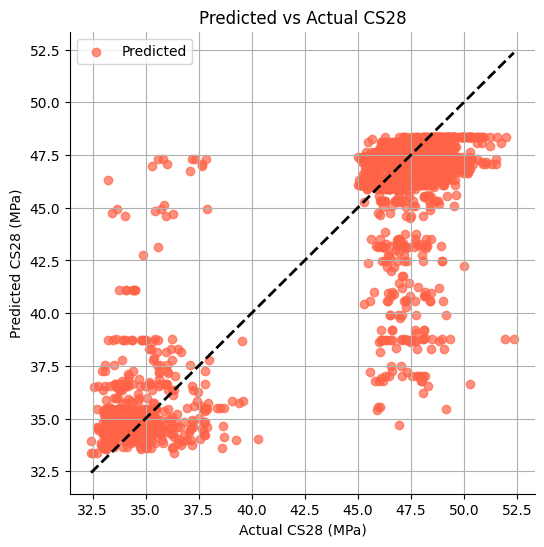

<IPython.core.display.Javascript object>

In [54]:
# Scatter plot of actual vs predicted values
test_data = df_pred[df_pred["SET"] == "TEST"]
plt.figure(figsize=(6, 6))
plt.scatter(
    test_data["CS28"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    label="Predicted",
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    color="black",
    linestyle="--",
    linewidth=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "ecics_203_c_local_cm_tiss_dominant_top_one_pred_vs_actual_cs28.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

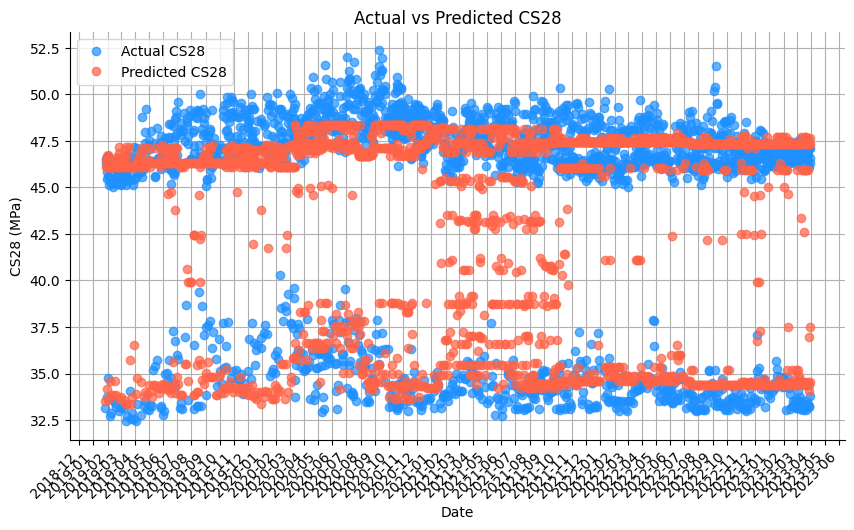

<IPython.core.display.Javascript object>

In [55]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(10, 6))
plt.plot(
    test_data["DATE"],
    test_data["CS28"],
    color="dodgerblue",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Actual CS28",
)
plt.plot(
    test_data["DATE"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Predicted CS28",
)
plt.xlabel("Date")
plt.ylabel("CS28 (MPa)")
plt.title("Actual vs Predicted CS28")
plt.legend()
plt.grid(True)

# Improving x-axis readability
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Set ticks for each month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format date as 'YYYY-MM-DD'
plt.gcf().autofmt_xdate(rotation=45)  # Rotate x-axis labels

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "ecics_203_c_local_cm_tiss_dominant_top_one_pred_vs_actual_cs28_over_time.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


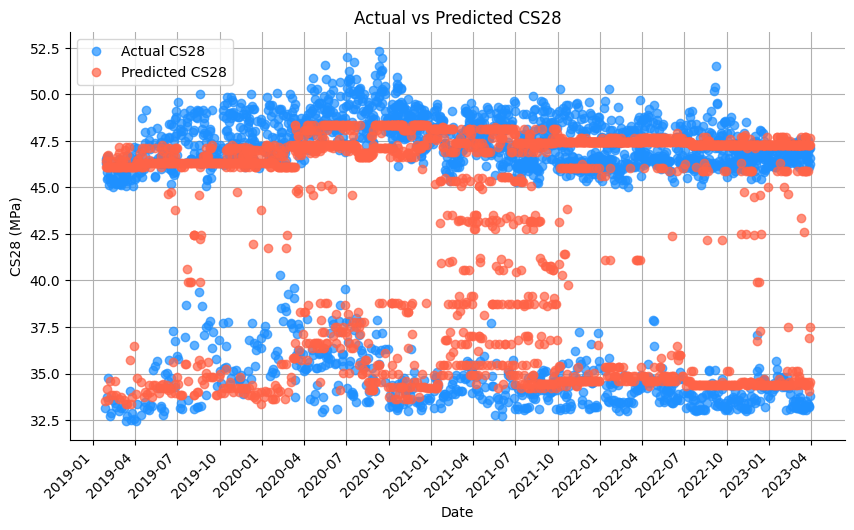

<IPython.core.display.Javascript object>

In [56]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(10, 6))
plt.plot(
    test_data["DATE"],
    test_data["CS28"],
    color="dodgerblue",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Actual CS28",
)
plt.plot(
    test_data["DATE"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Predicted CS28",
)
plt.xlabel("Date")
plt.ylabel("CS28 (MPa)")
plt.title("Actual vs Predicted CS28")
plt.legend()
plt.grid(True)

# Improved x-axis readability
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Display every 3rd month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format date as 'YYYY-MM'
plt.gcf().autofmt_xdate(rotation=45)  # Rotate x-axis labels for clarity

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "ecics_203_c_local_cm_tiss_dominant_top_one_pred_vs_actual_cs28_over_time.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


## Assessing Feature Importance

In [57]:
df_importances = get_random_forest_df_importances(scores)

<IPython.core.display.Javascript object>

In [58]:
df_importances

,CaO,MgO,Na2O,Al2O3,SiO2,SO3,K2O,TiO2,Fe2O3,Loss on Ignition,Insoluble Residue
Importances - 0,0.781969,0.000351,0.000287,0.002034,0.000497,0.201235,0.000434,0.001681,0.001918,0.003260,0.006334
Importances - 1,0.786850,0.006182,0.000000,0.000453,0.000417,0.195349,0.000000,0.000000,0.003847,0.002976,0.003927
Importances - 2,0.937074,0.007194,0.000000,0.000000,0.005011,0.029485,0.000000,0.000000,0.010788,0.010448,0.000000
Importances - 3,0.028830,0.001427,0.000396,0.000000,0.580457,0.378563,0.004320,0.000000,0.004348,0.000000,0.001659
Importances - 4,0.049920,0.002327,0.000766,0.000000,0.212312,0.730789,0.000000,0.000000,0.000275,0.000368,0.003243


<IPython.core.display.Javascript object>

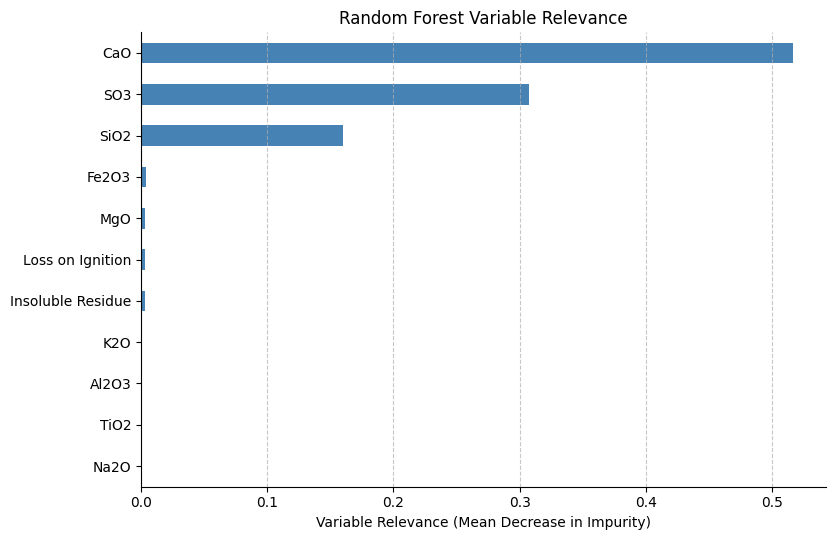

<IPython.core.display.Javascript object>

In [59]:
df_importances.mean(axis=0).sort_values().plot(
    kind="barh", figsize=(10, 5.5), color="steelblue"  # Consider using 'steelblue'
)
plt.title("Random Forest Variable Relevance")
plt.xlabel("Variable Relevance (Mean Decrease in Impurity)")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
plt.subplots_adjust(left=0.3)
plt.show()

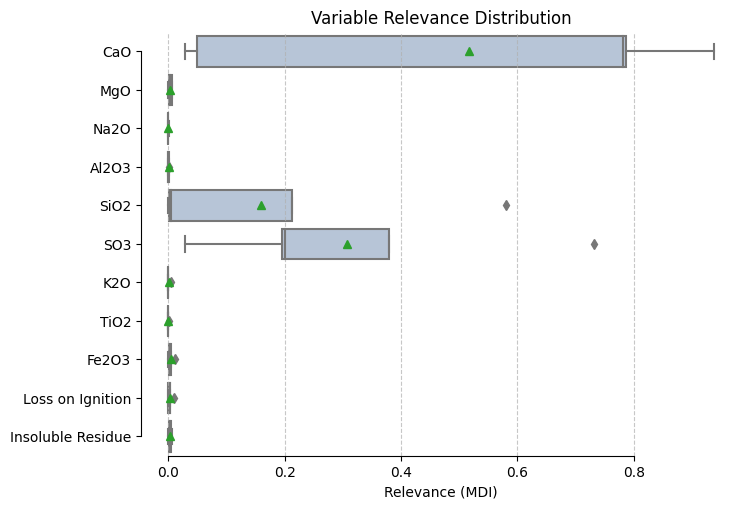

<IPython.core.display.Javascript object>

In [60]:
warnings.filterwarnings("ignore")
plt.figure(figsize=(10, 5.5))
sns.boxplot(data=df_importances, orient="h", color="lightsteelblue", saturation=0.7, showmeans=True)
sns.despine(trim=True, left=False)
plt.xlabel("Relevance (MDI)")
plt.title("Variable Relevance Distribution")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.show()


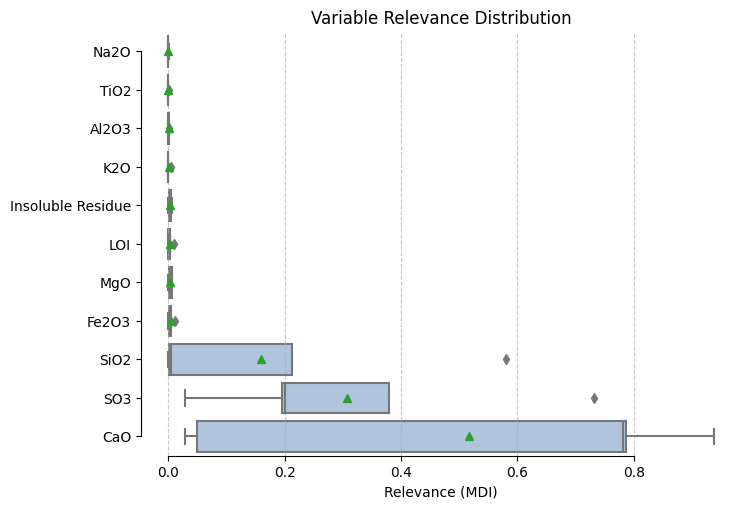

<IPython.core.display.Javascript object>

In [61]:
# Calculate the means of the importance scores
mean_importances = df_importances.mean()

# Sort the features by their mean relevance
sorted_features = mean_importances.sort_values()

# Re-order the DataFrame according to the sorted features
df_importances_sorted = df_importances[sorted_features.index]

# Plot the sorted boxplot
df_importances_sorted = df_importances_sorted.rename(
    columns={"Loss on Ignition": "LOI"}
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=df_importances_sorted,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Relevance (MDI)")
plt.title("Variable Relevance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_203_c_local_cm_tiss_random_forest_dominant_top_one_best_dist_var_relevance.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

In [62]:
print("Default font family:", matplotlib.rcParams["font.family"])
print("Default sans-serif fonts:", matplotlib.rcParams["font.sans-serif"])
print("Default font size:", matplotlib.rcParams["font.size"])
print("Default font weight:", matplotlib.rcParams["font.weight"])

Default font family: ['sans-serif']
Default sans-serif fonts: ['DejaVu Sans', 'Bitstream Vera Sans', 'Computer Modern Sans Serif', 'Lucida Grande', 'Verdana', 'Geneva', 'Lucid', 'Arial', 'Helvetica', 'Avant Garde', 'sans-serif']
Default font size: 10.0
Default font weight: normal


<IPython.core.display.Javascript object>

In [63]:
plt.get_backend()

'module://matplotlib_inline.backend_inline'

<IPython.core.display.Javascript object>

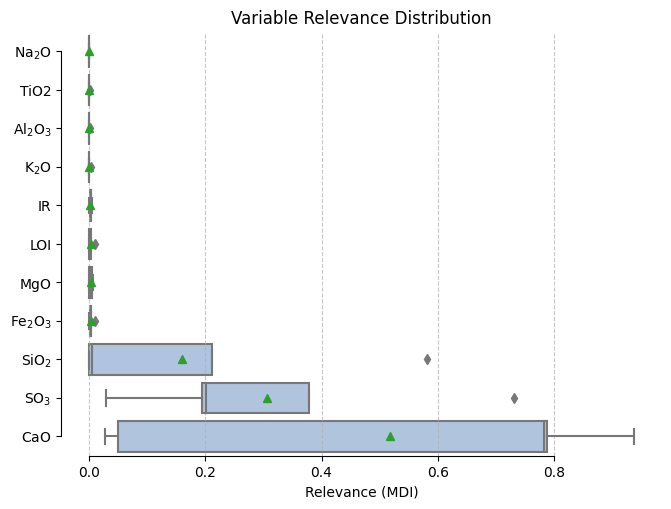

<IPython.core.display.Javascript object>

In [64]:
# Backup the original backend
original_backend = plt.get_backend()

# Use Matplotlib's default backend
# plt.switch_backend("agg")  # or any backend you prefer

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)

# plt.rcParams.update(
#     {
#         "mathtext.fontset": "custom",
#         "mathtext.rm": "DejaVu Sans",
#         "mathtext.it": "DejaVu Sans:italic",
#         "mathtext.bf": "DejaVu Sans:bold",
#     }
# )


# Convert chemical formulas using MathText syntax
df_importances_sorted_plot = df_importances_sorted.rename(
    columns={
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
    }
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=df_importances_sorted_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Relevance (MDI)")
plt.title("Variable Relevance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_203_c_local_cm_tiss_random_forest_dominant_top_one_best_dist_var_relevance.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()


# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

In [65]:
df_importances

,CaO,MgO,Na2O,Al2O3,SiO2,SO3,K2O,TiO2,Fe2O3,Loss on Ignition,Insoluble Residue
Importances - 0,0.781969,0.000351,0.000287,0.002034,0.000497,0.201235,0.000434,0.001681,0.001918,0.003260,0.006334
Importances - 1,0.786850,0.006182,0.000000,0.000453,0.000417,0.195349,0.000000,0.000000,0.003847,0.002976,0.003927
Importances - 2,0.937074,0.007194,0.000000,0.000000,0.005011,0.029485,0.000000,0.000000,0.010788,0.010448,0.000000
Importances - 3,0.028830,0.001427,0.000396,0.000000,0.580457,0.378563,0.004320,0.000000,0.004348,0.000000,0.001659
Importances - 4,0.049920,0.002327,0.000766,0.000000,0.212312,0.730789,0.000000,0.000000,0.000275,0.000368,0.003243


<IPython.core.display.Javascript object>

In [66]:
df_importances.describe().T

,count,mean,std,min,25%,50%,75%,max
CaO,5.0,0.516929,0.440444,0.028830,0.049920,0.781969,0.786850,0.937074
MgO,5.0,0.003496,0.003018,0.000351,0.001427,0.002327,0.006182,0.007194
Na2O,5.0,0.000290,0.000318,0.000000,0.000000,0.000287,0.000396,0.000766
Al2O3,5.0,0.000497,0.000881,0.000000,0.000000,0.000000,0.000453,0.002034
SiO2,5.0,0.159739,0.252215,0.000417,0.000497,0.005011,0.212312,0.580457
SO3,5.0,0.307084,0.267107,0.029485,0.195349,0.201235,0.378563,0.730789
K2O,5.0,0.000951,0.001893,0.000000,0.000000,0.000000,0.000434,0.004320
TiO2,5.0,0.000336,0.000752,0.000000,0.000000,0.000000,0.000000,0.001681
Fe2O3,5.0,0.004235,0.004005,0.000275,0.001918,0.003847,0.004348,0.010788
Loss on Ignition,5.0,0.003410,0.004202,0.000000,0.000368,0.002976,0.003260,0.010448


<IPython.core.display.Javascript object>

In [67]:
df_importances.mean(axis=0)

CaO                  0.516929
MgO                  0.003496
Na2O                 0.000290
Al2O3                0.000497
SiO2                 0.159739
SO3                  0.307084
K2O                  0.000951
TiO2                 0.000336
Fe2O3                0.004235
Loss on Ignition     0.003410
Insoluble Residue    0.003033
dtype: float64

<IPython.core.display.Javascript object>

In [68]:
df_importances.std(axis=0)

CaO                  0.440444
MgO                  0.003018
Na2O                 0.000318
Al2O3                0.000881
SiO2                 0.252215
SO3                  0.267107
K2O                  0.001893
TiO2                 0.000752
Fe2O3                0.004005
Loss on Ignition     0.004202
Insoluble Residue    0.002389
dtype: float64

<IPython.core.display.Javascript object>

In [69]:
df_importances.std(axis=0, ddof=0)

CaO                  0.393945
MgO                  0.002699
Na2O                 0.000285
Al2O3                0.000788
SiO2                 0.225588
SO3                  0.238908
K2O                  0.001693
TiO2                 0.000672
Fe2O3                0.003582
Loss on Ignition     0.003759
Insoluble Residue    0.002137
dtype: float64

<IPython.core.display.Javascript object>

In [70]:
df_copy.nunique()

Date                 1515
CaO                   973
MgO                   326
Na2O                   48
Al2O3                 315
SiO2                  850
SO3                   235
K2O                   109
TiO2                   41
Fe2O3                 186
Loss on Ignition      494
Insoluble Residue     294
dtype: int64

<IPython.core.display.Javascript object>

In [71]:
pipeline.named_steps

{'imputer': SimpleImputer(strategy='median'),
 'estimator': RandomForestRegressor(max_depth=3, n_estimators=5, random_state=47)}

<IPython.core.display.Javascript object>

In [72]:
from sklearn.inspection import permutation_importance

<IPython.core.display.Javascript object>

In [73]:
# Initialize lists to store importance results
mdi_importances = []
perm_importances = []

# Compute feature importances
for i, (train_idx, test_idx) in enumerate(cv.split(x, y)):
    pipeline.fit(x.iloc[train_idx], y[train_idx])

    # Extract the trained model
    model = pipeline.named_steps["estimator"]
    imputer = pipeline.named_steps["imputer"]
    # Compute MDI importance
    mdi_importances.append(model.feature_importances_)

    # Compute permutation importance
    result = permutation_importance(
        model,
        imputer.transform(x.iloc[test_idx]),
        y[test_idx],
        n_repeats=10,
        random_state=SEED,
        n_jobs=-1,
        # scoring="neg_mean_squared_error",
        scoring="r2",
    )
    perm_importances.append(result.importances_mean)

<IPython.core.display.Javascript object>

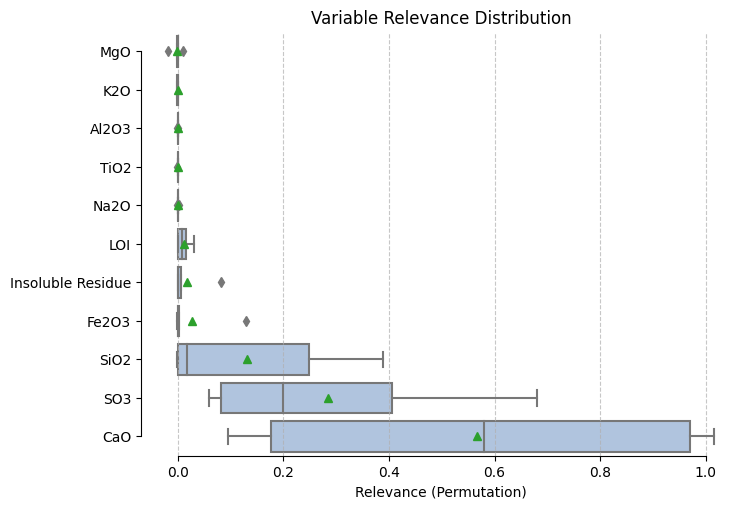

<IPython.core.display.Javascript object>

In [74]:
# Convert lists to DataFrames
mdi_importances_df = pd.DataFrame(mdi_importances, columns=x.columns)
perm_importances_df = pd.DataFrame(perm_importances, columns=x.columns)


# Calculate the mean importance for each feature
mean_importances = perm_importances_df.mean().sort_values()

# Reorder the DataFrame columns based on mean importance
perm_importances_df = perm_importances_df[mean_importances.index]

perm_importances_df = perm_importances_df.rename(columns={"Loss on Ignition": "LOI"})


plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=perm_importances_df,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Relevance (Permutation)")
plt.title("Variable Relevance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_203_c_local_cm_tiss_random_forest_dominant_top_one_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)

# # Step 3: Reset all rcParams to their default values
plt.rcdefaults()

plt.show()

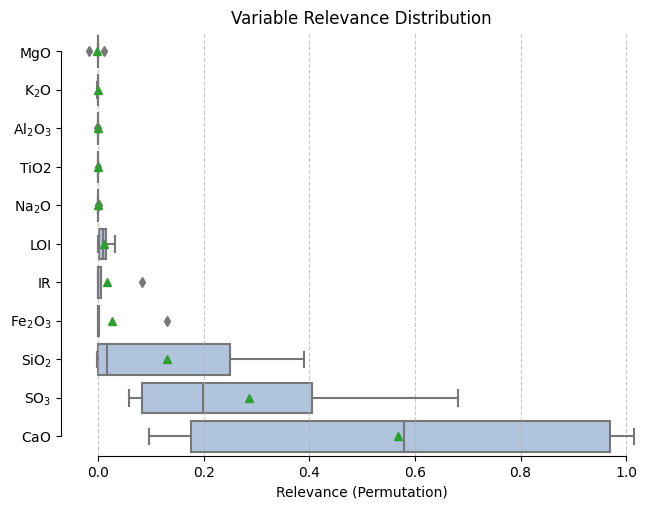

<IPython.core.display.Javascript object>

In [75]:
# Backup the original backend
original_backend = plt.get_backend()

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)

# Convert chemical formulas using MathText syntax
perm_importances_df_plot = perm_importances_df.rename(
    columns={
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
    }
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=perm_importances_df_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Relevance (Permutation)")
plt.title("Variable Relevance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_203_c_local_cm_tiss_random_forest_dominant_top_one_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)


# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

plt.show()

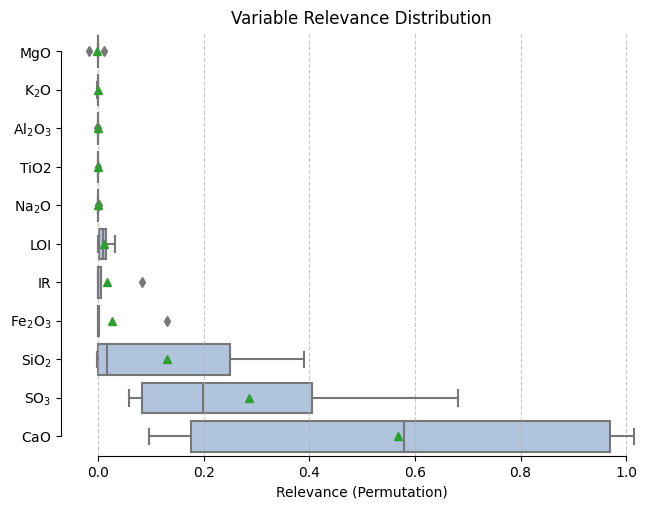

<IPython.core.display.Javascript object>

In [76]:
import matplotlib.ticker as mticker

# Step 1: Define a function to format the x-axis to one decimal place
def one_decimal(x, pos):
    return f'{x:.1f}'

# Backup the original backend
original_backend = plt.get_backend()

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)

# Convert chemical formulas using MathText syntax
perm_importances_df_plot = perm_importances_df.rename(
    columns={
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR"
    }
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=perm_importances_df_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Relevance (Permutation)")
plt.title("Variable Relevance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)

# Step 2: Apply the formatter to the x-axis
ax = plt.gca()  # Get the current axis
ax.xaxis.set_major_formatter(mticker.FuncFormatter(one_decimal))

plt.savefig(
    "ecics_203_c_local_cm_tiss_random_forest_dominant_top_one_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)

# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

plt.show()


In [77]:
perm_importances_df.describe().T

,count,mean,std,min,25%,50%,75%,max
MgO,5.0,-0.001639,0.010313,-0.017995,-0.001079,-0.000043,0.000255,0.010668
K2O,5.0,-0.000442,0.000686,-0.001563,-0.000645,0.000000,0.000000,0.000000
Al2O3,5.0,-0.000264,0.000599,-0.001335,0.000000,0.000000,0.000000,0.000014
TiO2,5.0,-0.000210,0.000469,-0.001048,0.000000,0.000000,0.000000,0.000000
Na2O,5.0,0.000257,0.000964,-0.000509,-0.000147,0.000000,0.000000,0.001941
LOI,5.0,0.011400,0.013004,0.000000,0.000838,0.008908,0.015574,0.031679
Insoluble Residue,5.0,0.017601,0.036203,0.000000,0.000000,0.000114,0.005676,0.082215
Fe2O3,5.0,0.026271,0.058125,-0.000929,-0.000286,0.000020,0.002326,0.130225
SiO2,5.0,0.130602,0.179318,-0.002293,0.000155,0.016599,0.249448,0.389100
SO3,5.0,0.285437,0.260009,0.059222,0.082822,0.198920,0.405418,0.680800


<IPython.core.display.Javascript object>

In [78]:
perm_importances_df

,MgO,K2O,Al2O3,TiO2,Na2O,LOI,Insoluble Residue,Fe2O3,SiO2,SO3,CaO
0,-0.000043,-0.000645,-0.001335,-0.001048,0.001941,0.008908,0.082215,-0.000286,-0.002293,0.082822,1.015138
1,0.010668,0.000000,0.000014,0.000000,0.000000,0.015574,0.005676,-0.000929,0.000155,0.059222,0.970014
2,-0.017995,0.000000,0.000000,0.000000,0.000000,0.031679,0.000000,0.130225,0.016599,0.198920,0.580181
3,0.000255,-0.001563,0.000000,0.000000,-0.000509,0.000000,0.000000,0.002326,0.389100,0.405418,0.176250
4,-0.001079,0.000000,0.000000,0.000000,-0.000147,0.000838,0.000114,0.000020,0.249448,0.680800,0.095634


<IPython.core.display.Javascript object>

In [79]:
perm_importances_df.mean(axis=0)

MgO                 -0.001639
K2O                 -0.000442
Al2O3               -0.000264
TiO2                -0.000210
Na2O                 0.000257
LOI                  0.011400
Insoluble Residue    0.017601
Fe2O3                0.026271
SiO2                 0.130602
SO3                  0.285437
CaO                  0.567444
dtype: float64

<IPython.core.display.Javascript object>

In [80]:
perm_importances_df.std(axis=0, ddof=0)

MgO                  0.009224
K2O                  0.000614
Al2O3                0.000535
TiO2                 0.000419
Na2O                 0.000862
LOI                  0.011631
Insoluble Residue    0.032381
Fe2O3                0.051989
SiO2                 0.160387
SO3                  0.232559
CaO                  0.384263
dtype: float64

<IPython.core.display.Javascript object>

# Top two dominant model - Transformer 7 TS - SCPM: -5.56 | dominance counts: 116

In [81]:
# Database Reading and Manipulation
import pandas as pd

# Linear Algebra
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# Time
import time

# Random and os for reproducibility
import random
import os

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

# Modeling
import tensorflow as tf

# Processing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

# Pipeline
from sklearn.pipeline import Pipeline

# Data imputation
from sklearn.impute import SimpleImputer

# Making keras compatible with scikit learn api
# https://scikit-learn.org/stable/developers/develop.html
from sklearn.base import BaseEstimator, RegressorMixin

# Custom modules
## Model selection
from src.cross_validation.blocking_time_series_split import BlockingTimeSeriesSplit

## Function to print scores
from src.utils.print_scores import print_scores

## Function to calculate score regression metrics
from src.utils.score_regression_metrics import score_regression_metrics

## Function to fill the results metric dict
from src.utils.fill_results_dict import fill_results_dict

# Converting Times Series Data to 3D format
from src.utils.split_sequences import split_sequences

# Transformer Encoder for time series data
from src.models.transformer_ts_tf import Transformer

# To run cross validation parallelized
from joblib import Parallel, delayed

import joblib

import matplotlib

2024-11-01 02:38:28.201351: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-01 02:38:28.203757: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-01 02:38:28.246860: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-01 02:38:28.248467: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-01 02:38:29.115062: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

<IPython.core.display.Javascript object>

## Functions and definitions

### Convert train/test data to 3D format

In [82]:
def generate_sequences_helper(
    dataset, cement_types, dates=None, timesteps=None, split_by_cement_type=False
):
    index_train = dataset["y_train"].index
    index_test = dataset["y_test"].index

    dataset["y_train"] = dataset["y_train"].reset_index(drop=True)
    dataset["y_test"] = dataset["y_test"].reset_index(drop=True)

    if dates is not None:
        dataset["dates_train"] = dates[index_train].reset_index(drop=True)
        dataset["dates_test"] = dates[index_test].reset_index(drop=True)

    dataset["cement_types_train"] = cement_types.loc[index_train].reset_index(drop=True)
    dataset["cement_types_test"] = cement_types.loc[index_test].reset_index(drop=True)

    dataset = generate_sequences(dataset, timesteps, split_by_cement_type)

    return dataset

<IPython.core.display.Javascript object>

In [83]:
def generate_sequences(dataset, timesteps, split_by_cement_type=False):
    if split_by_cement_type:
        dataset["x_train"], dataset["y_train"] = split_sequences_per_cement_type(
            pd.concat(
                [
                    dataset["dates_train"],
                    pd.DataFrame(dataset["x_train"], columns=x.columns),
                    dataset["cement_types_train"],
                    dataset["y_train"],
                ],
                axis=1,
            ),
            timesteps,
        )

        dataset["x_test"], dataset["y_test"] = split_sequences_per_cement_type(
            pd.concat(
                [
                    dataset["dates_test"],
                    pd.DataFrame(dataset["x_test"], columns=x.columns),
                    dataset["cement_types_test"],
                    dataset["y_test"],
                ],
                axis=1,
            ),
            timesteps,
        )
    else:
        dataset["x_train"], dataset["y_train"] = split_sequences(
            pd.concat(
                [
                    pd.DataFrame(dataset["x_train"], columns=x.columns),
                    dataset["y_train"],
                ],
                axis=1,
            ).values,
            timesteps,
        )

        dataset["x_test"], dataset["y_test"] = split_sequences(
            pd.concat(
                [
                    pd.DataFrame(dataset["x_test"], columns=x.columns),
                    dataset["y_test"],
                ],
                axis=1,
            ).values,
            timesteps,
        )
    return dataset

<IPython.core.display.Javascript object>

In [84]:
def impute_data(dataset, imputer=None, imputer_params=None):
    x_train = dataset["x_train"]
    x_test = dataset["x_test"]

    # Apply imputation to the data
    if imputer is not None:
        imputer = imputer() if imputer_params is None else imputer(**imputer_params)
        x_train = imputer.fit_transform(x_train)
        x_test = imputer.transform(x_test)

    dataset["x_train"] = x_train
    dataset["x_test"] = x_test

    return imputer, dataset

<IPython.core.display.Javascript object>

In [85]:
def transform_data(dataset, transformer=None):
    x_train = dataset["x_train"]
    x_test = dataset["x_test"]

    # Apply data normalization/standardization to the data
    if transformer is not None:
        scaler = transformer()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)

    dataset["x_train"] = x_train
    dataset["x_test"] = x_test

    return scaler, dataset

<IPython.core.display.Javascript object>

In [86]:
def preprocess_data(dataset, transformer=None, imputer=None, imputer_params=None):
    imputer, dataset = impute_data(dataset, imputer, imputer_params)
    scaler, dataset = transform_data(dataset, transformer)
    return imputer, scaler, dataset

<IPython.core.display.Javascript object>

In [87]:
def train_and_evaluate_model(Estimator, dataset, estimator_params=None):
    """
    Purpose: Helper function to be used in conjunction with
    blocked time_series cross validation function
    """
    x_train = dataset["x_train"]
    y_train = dataset["y_train"]
    x_test = dataset["x_test"]
    y_test = dataset["y_test"]

    # Instantiate the model
    model = Estimator() if estimator_params is None else Estimator(**estimator_params)

    # Fitting the model
    model.fit(x_train, y_train)

    # Making predictions on train/test sets
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    # Return regression metrics
    return model, score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)

<IPython.core.display.Javascript object>

In [88]:
def custom_cross_validate_parallelized(
    Estimator,
    Imputer,
    Transform,
    x,
    y,
    cv,
    timesteps,
    dates=None,
    cement_types=None,
    estimator_params=None,
    imputer_params=None,
    split_by_cement_type=True,
    n_jobs=-1,
    REPEAT=0,  # Add REPEAT as a parameter
):
    def process_fold(
        train_index, test_index, dates, cement_types, x, y, repeat_num, fold_num
    ):
        dataset = {
            "dates_train": dates[train_index].reset_index(drop=True),
            "cement_types_train": cement_types.loc[train_index].reset_index(drop=True),
            "x_train": x.loc[train_index].reset_index(drop=True),
            "y_train": y[train_index].reset_index(drop=True),
            "dates_test": dates[test_index].reset_index(drop=True),
            "cement_types_test": cement_types.loc[test_index].reset_index(drop=True),
            "x_test": x.loc[test_index].reset_index(drop=True),
            "y_test": y[test_index].reset_index(drop=True),
        }

        set_seeds(SEED + repeat_num)

        # Preprocess the dataset
        imputer, scaler, dataset = preprocess_data(
            dataset, Transform, Imputer, imputer_params
        )

        # Generate sequences (3D format)
        dataset = generate_sequences(dataset, timesteps, split_by_cement_type)

        # Train and Evaluate the model
        estimator, score = train_and_evaluate_model(
            Estimator, dataset, estimator_params
        )

        # Create a directory to save models if it doesn't exist
        model_dir = f"models_repeat{repeat_num}_fold{fold_num}"
        os.makedirs(model_dir, exist_ok=True)

        # Save the imputer
        imputer_filename = os.path.join(model_dir, f"imputer.joblib")
        joblib.dump(imputer, imputer_filename)

        # Save the scaler
        scaler_filename = os.path.join(model_dir, f"scaler.joblib")
        joblib.dump(scaler, scaler_filename)

        # Save the Keras model
        # model_filename = os.path.join(model_dir, f"keras_model.h5")
        # estimator.model.save(model_filename)
        # Save the Keras model in SavedModel format
        model_filename = os.path.join(model_dir, f"keras_model")  # No extension
        estimator.model.save(model_filename, save_format="tf")  # Specify save_format

        # Optionally, return the filenames
        filenames = {
            "imputer": imputer_filename,
            "scaler": scaler_filename,
            "model": model_filename,
        }

        return score, filenames

    # Use enumerate to get fold numbers
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_fold)(
            train_index, test_index, dates, cement_types, x, y, REPEAT, fold_num
        )
        for fold_num, (train_index, test_index) in enumerate(cv.split(x))
    )

    # Unpack scores and filenames
    scores, filenames_list = zip(*results)

    # Process scores as before
    scores_final = {key: [] for key, _ in scores[0].items()}
    for scores_dict in scores:
        for key, value in scores_dict.items():
            scores_final[key] += [value]

    # Optionally, collect filenames
    # filenames_list contains the filenames for each fold

    results = [scores_final]
    return filenames_list, results

<IPython.core.display.Javascript object>

In [89]:
class TransformerWrapper(RegressorMixin):
    def __init__(self, params):
        self.params = params
        self.model = self.get_model()
        self.batch_size = 16
        self.epochs = 300
        self.verbose = 0

    def fit(self, X=None, y=None):
        self.model.fit(
            X, y, batch_size=self.batch_size, epochs=self.epochs, verbose=self.verbose
        )

    def predict(self, X=None):
        return self.model.predict(X, verbose=self.verbose)

    def get_model(self):
        model = Transformer(
            num_hid=self.params["num_features"],
            time_steps=self.params["timesteps"],
            num_head=self.params["num_heads"],
            num_layers_enc=self.params["num_layers_enc"],
            num_feed_forward=self.params["num_feed_forward"],
        )
        model.compile(
            tf.keras.optimizers.Adam(learning_rate=0.001),
            loss="mse",
            metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
        )
        return model

<IPython.core.display.Javascript object>

In [90]:
def pad_time_series(dataframe, timesteps):
    """
    Pad timeseries with zeros
    """
    df_tmp = pd.DataFrame(
        dict(
            zip(
                dataframe.columns,
                [[0 for _ in range(timesteps - 1)] for _ in range(dataframe.shape[1])],
            )
        )
    )
    df_tmp[DATE] = dataframe[DATE].iloc[0]
    return pd.concat([df_tmp, dataframe], axis=0).reset_index(drop=True)

<IPython.core.display.Javascript object>

In [91]:
def split_sequences_per_cement_type(dataframe, timesteps, pad=False):
    """
    Create sequences per cement time
    to avoid having parts of the sequence
    of different types of cement.
    """
    if timesteps == 1:
        return split_sequences(
            dataframe.drop([DATE] + CEMENT_TYPES, axis=1).values, timesteps
        )

    dates = dataframe[DATE][timesteps - 1 :]
    data = []
    dataframes = []

    for cement_type in CEMENT_TYPES:
        data.append(dataframe[dataframe[cement_type] == 1])
    data.append(dataframe[(dataframe[CEMENT_TYPES] == 0).all(axis=1)])

    for df in data:
        if pad:
            dates = df[DATE].reset_index(drop=True)
            df = pad_time_series(df, timesteps).reset_index(drop=True)
        else:
            dates = df[DATE][timesteps - 1 :].reset_index(drop=True)
        x, y = split_sequences(df.drop([DATE] + CEMENT_TYPES, axis=1).values, timesteps)
        x = pd.DataFrame({"Sequences": [sample.tolist() for sample in x]})
        y = pd.DataFrame({"Target": y})
        dataframes.append(pd.concat([dates, x, y], axis=1))

    data = pd.concat(dataframes, axis=0)
    data[DATE] = pd.to_datetime(data[DATE])
    data = data.sort_values(by=DATE).reset_index(drop=True)
    x = data["Sequences"]
    y = data["Target"].values
    x = np.array(x.tolist())

    return x, y

<IPython.core.display.Javascript object>

In [92]:
SEED = 47
REPEAT = 0

<IPython.core.display.Javascript object>

In [93]:
def set_seeds(seed=SEED):
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)


# https://stackoverflow.com/questions/36288235/how-to-get-stable-results-with-tensorflow-setting-random-seed

<IPython.core.display.Javascript object>

In [94]:
def set_global_determinism():
    set_seeds(seed=SEED)

    os.environ["TF_DETERMINISTIC_OPS"] = "1"
    os.environ["TF_CUDNN_DETERMINISTIC"] = "1"

    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

<IPython.core.display.Javascript object>

In [95]:
def get_transformer_params(
    timesteps=1,
    num_features=0,
    num_heads=1,
    num_layers_enc=1,
    num_feed_forward=16,
    dropout_rate=0.1,
    activation="relu",
    batch_size=64,
    epochs=300,
    callbacks=None,
    validation_split=0.0,
    verbose=0,
):
    params = {}
    params["num_features"] = num_features
    params["timesteps"] = timesteps
    params["num_heads"] = num_heads
    params["num_layers_enc"] = num_layers_enc
    params["num_feed_forward"] = num_feed_forward
    params["verbose"] = verbose
    params["dropout_rate"] = dropout_rate
    params["activation"] = activation
    params["batch_size"] = batch_size
    params["epochs"] = epochs
    params["callbacks"] = callbacks
    params["validation_split"] = validation_split

    return params

<IPython.core.display.Javascript object>

In [96]:
METRICS = (
    "neg_root_mean_squared_error",
    "neg_mean_absolute_error",
    "neg_mean_absolute_percentage_error",
    "r2",
)
METRICS_DICT = {
    "neg_root_mean_squared_error": "RMSE",
    "neg_mean_absolute_error": "MAE",
    "neg_mean_absolute_percentage_error": "MAPE",
    "r2": "R2",
}
DATE = "Date"
CEMENT_TYPES = [
    "Cement_Type_CP II-E40",
    "Cement_Type_CP II-F40",
    "Cement_Type_CP VARI",
]

<IPython.core.display.Javascript object>

In [97]:
df_copy = df.copy()
df_copy = pd.get_dummies(data=df_copy, columns=["Cement_Type"], drop_first=True)

df_copy = df_copy.drop(
    [
        "Blaine",
        "#200",
        "#325",
        "Final setting time",
        "Initial setting time",
        "CS1",
        "CS3",
        "CS7",
    ],
    axis=1,
)

<IPython.core.display.Javascript object>

In [98]:
df_copy[CEMENT_TYPES] = df_copy[CEMENT_TYPES].astype(int)
dates = df["Date"].copy()
y = df_copy.pop("CS28")
x = df_copy
df_copy = pd.concat([x, y], axis=1)

<IPython.core.display.Javascript object>

# Transformer Encoder

In [99]:
params = {}
params["timesteps"] = None
params["num_features"] = None
params["num_heads"] = 1
params["num_layers_enc"] = 1
params["num_feed_forward"] = 16

<IPython.core.display.Javascript object>

## 1.3. Time Series Cross Validation

In [100]:
start = time.time()

repeats = 3
n_splits = 5
train_size = 0.8
gap = 0
TIMESTEPS_LIST = [7]
REPEAT = 0
filenames_lists = {}
print("Blocking Time Series Split:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()

for timesteps in TIMESTEPS_LIST:
    set_seeds()
    scores_final = None

    params["timesteps"] = timesteps

    for repeat in range(repeats):
        REPEAT = repeat
        x = df_copy.drop(["Date", "CS28"] + CEMENT_TYPES, axis=1)
        y = df_copy["CS28"]
        params["num_features"] = x.shape[-1]

        cv = TimeSeriesSplit(
            gap=gap, max_train_size=None, n_splits=n_splits, test_size=None
        )

        filenames_list, scores = custom_cross_validate_parallelized(
            TransformerWrapper,
            SimpleImputer,
            StandardScaler,
            x,
            y,
            cv,
            timesteps,
            dates=dates,
            cement_types=df_copy[CEMENT_TYPES],
            estimator_params={"params": params},
            imputer_params={"strategy": "median"},
            split_by_cement_type=True,
            REPEAT=REPEAT,
        )
        filenames_lists[repeat] = filenames_list
        scores = scores[0]
        if scores_final is None:
            scores_final = {key: [] for key, _ in scores.items()}

        for key, value in scores.items():
            scores_final[key] += [value]

    print("TIMESTEPS: %d " % timesteps)
    print_scores(scores_final, METRICS, METRICS_DICT)

    # Saving the results
    scores = {key: np.array(val).flatten() for key, val in scores_final.items()}
    results_dict_copy = results_dict.copy()
    results_dict_copy["Timesteps"] = timesteps
    results_dict_copy["Cross Validation"] = "Blocking Time Series Split"
    results_dict_copy[
        "Cross Validation Params"
    ] = '{"N_Splits": 5, "Repeats": 3, "train_size": 0.8}'
    results_dict_copy["Data Shape"] = x.shape
    df_results = fill_results_dict(results_dict_copy, scores)
    results_to_save.append(df_results)

end = time.time()
print("Minutes Elapsed: ", (end - start) / 60)

Blocking Time Series Split:
Repeats: 3
n_splits: 5



2024-11-01 02:38:32.413947: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-01 02:38:32.416574: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-01 02:38:32.446784: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-01 02:38:32.449246: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-01 02:38:32.477210: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024

2024-11-01 02:43:33.328877: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-11-01 02:43:33.353815: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-11-01 02:43:33.353828: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-11-01 02:43:33.391921: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-11-01 02:43:33.400590: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-11-01 02:43:34.431623: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering G

2024-11-01 02:48:27.302690: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


TIMESTEPS: 7 
******
[TRAIN]
******
RMSE: 0.975 (0.045)
MAE: 0.753 (0.041)
MAPE: 0.018 (0.001)
R2: 0.973 (0.002)


******
[TEST]
******
RMSE: 2.245 (0.483)
MAE: 1.606 (0.319)
MAPE: 0.039 (0.008)
R2: 0.847 (0.062)


Minutes Elapsed:  14.909018921852113


<IPython.core.display.Javascript object>

## Plotting the Predictions

In [101]:
from tensorflow.keras.models import load_model

pipelines_final = []

for repeat in range(repeats):
    for fold in range(n_splits):
        imputer_filename = filenames_lists[repeat][fold]["imputer"]
        scaler_filename = filenames_lists[repeat][fold]["scaler"]
        model_filename = filenames_lists[repeat][fold]["model"]

        # Load the imputer
        imputer = joblib.load(imputer_filename)
        # Load the scaler
        scaler = joblib.load(scaler_filename)
        # Load the Keras model
        estimator = load_model(model_filename)

        pipelines_final.append((imputer, scaler, estimator))

2024-11-01 02:53:26.732415: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


<IPython.core.display.Javascript object>

In [102]:
indices_final = {"train": [], "test": []}

for repeat in range(repeats):
    for train, test in cv.split(x):
        indices_final["train"].extend([train])
        indices_final["test"].extend([test])

<IPython.core.display.Javascript object>

In [103]:
len(indices_final["train"])

15

<IPython.core.display.Javascript object>

In [104]:
def split_sequences_per_cement_type_helper(dataframe, timesteps, pad=False):
    """
    Create sequences per cement time
    to avoid having parts of the sequence
    of different types of cement.
    """
    if timesteps == 1:
        x, y = split_sequences(
            dataframe.drop([DATE] + CEMENT_TYPES, axis=1).values, timesteps
        )
        return x, y, dataframe[DATE]

    dates = dataframe[DATE][timesteps - 1 :]
    data = []
    dataframes = []

    for cement_type in CEMENT_TYPES:
        data.append(dataframe[dataframe[cement_type] == 1])
    data.append(dataframe[(dataframe[CEMENT_TYPES] == 0).all(axis=1)])

    for df in data:
        if pad:
            dates = df[DATE].reset_index(drop=True)
            df = pad_time_series(df, timesteps).reset_index(drop=True)
        else:
            dates = df[DATE][timesteps - 1 :].reset_index(drop=True)
        x, y = split_sequences(df.drop([DATE] + CEMENT_TYPES, axis=1).values, timesteps)
        x = pd.DataFrame({"Sequences": [sample.tolist() for sample in x]})
        y = pd.DataFrame({"Target": y})
        dataframes.append(pd.concat([dates, x, y], axis=1))

    data = pd.concat(dataframes, axis=0)
    data[DATE] = pd.to_datetime(data[DATE])
    data = data.sort_values(by=DATE).reset_index(drop=True)
    x = data["Sequences"]
    y = data["Target"].values
    x = np.array(x.tolist())
    dates = data[DATE]

    return x, y, dates

<IPython.core.display.Javascript object>

In [105]:
def generate_sequences_helper(dataset, timesteps, split_by_cement_type=False):
    if split_by_cement_type:
        (
            dataset["x_train"],
            dataset["y_train"],
            dates_train,
        ) = split_sequences_per_cement_type_helper(
            pd.concat(
                [
                    dataset["dates_train"],
                    pd.DataFrame(dataset["x_train"], columns=x.columns),
                    dataset["cement_types_train"],
                    dataset["y_train"],
                ],
                axis=1,
            ),
            timesteps,
        )

        (
            dataset["x_test"],
            dataset["y_test"],
            dates_test,
        ) = split_sequences_per_cement_type_helper(
            pd.concat(
                [
                    dataset["dates_test"],
                    pd.DataFrame(dataset["x_test"], columns=x.columns),
                    dataset["cement_types_test"],
                    dataset["y_test"],
                ],
                axis=1,
            ),
            timesteps,
        )
        dataset["dates_train_seq"] = dates_train
        dataset["dates_test_seq"] = dates_test
    else:
        dataset["x_train"], dataset["y_train"] = split_sequences(
            pd.concat(
                [
                    pd.DataFrame(dataset["x_train"], columns=x.columns),
                    dataset["y_train"],
                ],
                axis=1,
            ).values,
            timesteps,
        )

        dataset["x_test"], dataset["y_test"] = split_sequences(
            pd.concat(
                [
                    pd.DataFrame(dataset["x_test"], columns=x.columns),
                    dataset["y_test"],
                ],
                axis=1,
            ).values,
            timesteps,
        )
    return dataset

<IPython.core.display.Javascript object>

In [106]:
# Store predictions for each fold
all_predictions = []
cement_types=df_copy[CEMENT_TYPES]
params["timesteps"]=timesteps

for idx, (imputer, scaler, estimator) in enumerate(pipelines_final):
    train_index = indices_final["train"][idx]
    test_index = indices_final["test"][idx]
    
    # Prepare dataset for prediction
    dataset = {
        "dates_train": dates.iloc[train_index].reset_index(drop=True),
        "cement_types_train": cement_types.iloc[train_index].reset_index(drop=True),
        "x_train": x.iloc[train_index].reset_index(drop=True),
        "y_train": y.iloc[train_index].reset_index(drop=True),
        "dates_test": dates.iloc[test_index].reset_index(drop=True),
        "cement_types_test": cement_types.iloc[test_index].reset_index(drop=True),
        "x_test": x.iloc[test_index].reset_index(drop=True),
        "y_test": y.iloc[test_index].reset_index(drop=True),
    }

    # Apply preprocessing
    dataset["x_train"] = imputer.transform(dataset["x_train"])
    dataset["x_test"] = imputer.transform(dataset["x_test"])

    dataset["x_train"] = scaler.transform(dataset["x_train"])
    dataset["x_test"] = scaler.transform(dataset["x_test"])

    # Generate sequences
    dataset = generate_sequences_helper(dataset, params["timesteps"], split_by_cement_type=True)

    if timesteps == 1:
    # Adjust dates for sequences
        dates_train = dataset["dates_train"][params["timesteps"] - 1:].reset_index(drop=True)
        dates_test = dataset["dates_test"][params["timesteps"] - 1:].reset_index(drop=True)
    else:
        dates_train = dataset["dates_train_seq"]#.reset_index(drop=True)
        dates_test = dataset["dates_test_seq"]#.reset_index(drop=True)

    # Make predictions
    y_train_pred = estimator.predict(dataset["x_train"], verbose=0).flatten()
    y_test_pred = estimator.predict(dataset["x_test"], verbose=0).flatten()

    # Store predictions along with fold information
    fold_predictions_train = pd.DataFrame({
        "DATE": dates_train,
        "CS28": dataset["y_train"],
        "CS28_PRED": y_train_pred,
        "SET": ["TRAIN"] * len(y_train_pred),
        "FOLD": [idx + 1] * len(y_train_pred),
        "REPEAT": [(idx)//5] * len(y_train_pred),
        #"INDEX": dates_train.index.values,
    })

    fold_predictions_test = pd.DataFrame({
        "DATE": dates_test,
        "CS28": dataset["y_test"],
        "CS28_PRED": y_test_pred,
        "SET": ["TEST"] * len(y_test_pred),
        "FOLD": [idx + 1] * len(y_test_pred),
        "REPEAT": [(idx)//5] * len(y_test_pred),
        #"INDEX": dates_test.index.values,
    })

    all_predictions.append(pd.concat([fold_predictions_train, fold_predictions_test], axis=0))


<IPython.core.display.Javascript object>

In [107]:
# df_pred = pd.concat(all_predictions).reset_index(drop=True)
# df_pred["DATE"] = pd.to_datetime(df_pred["DATE"])

# mean = pd.concat(
#     [
#         df_pred[df_pred["REPEAT"].eq(0)]["CS28_PRED"].reset_index(drop=True),
#         df_pred[df_pred["REPEAT"].eq(1)]["CS28_PRED"].reset_index(drop=True),
#         df_pred[df_pred["REPEAT"].eq(2)]["CS28_PRED"].reset_index(drop=True),
#     ],
#     axis=1,
# ).mean(axis=1)

# df_copy_merge = (
#     df_copy.drop(["Cement_Type_CP II-Z-32", "CS28"], axis=1)
#     .merge(df_pred, left_index=True, right_index=True, how="left")
#     .drop("REPEAT", axis=1)
# )

# df_copy_merge["COMPANY"] = 203
# df_copy_merge["PLANT"] = "C"
# df_copy_merge["CS28_PRED"] = mean

# df_copy_merge.to_excel("global_model_transformer_1ts_btsscv_203_c.xlsx", index=False)
# df_copy_merge.to_csv("global_model_transformer_1ts_btsscv_203_c.csv", index=False)

<IPython.core.display.Javascript object>

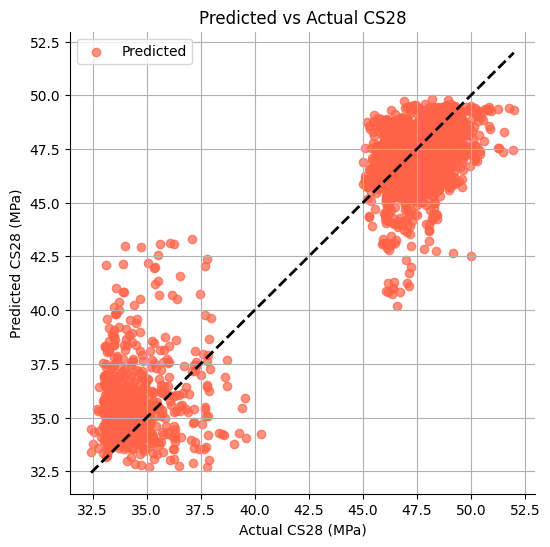

<IPython.core.display.Javascript object>

In [108]:
df_pred = pd.concat(all_predictions).reset_index(drop=True)
df_pred["DATE"] = pd.to_datetime(df_pred["DATE"])

# Proceed with your plotting code
# Scatter plot of actual vs predicted values
test_data = df_pred[df_pred["SET"] == "TEST"]

test_data_tmp = test_data[test_data["REPEAT"].eq(0)].copy().reset_index(drop=True)

mean = pd.concat(
    [test_data[test_data["REPEAT"].eq(0)]["CS28_PRED"].reset_index(drop=True),
    test_data[test_data["REPEAT"].eq(1)]["CS28_PRED"].reset_index(drop=True),
    test_data[test_data["REPEAT"].eq(2)]["CS28_PRED"].reset_index(drop=True)],
axis=1).mean(axis=1)

test_data_tmp["CS28_PRED"] = mean
test_data = test_data_tmp

# test_data = test_data.groupby("INDEX", as_index=False).agg(
#     {"DATE": "first", "CS28": "first", "CS28_PRED": "mean", "SET": "first", "FOLD": "first"}
# )
plt.figure(figsize=(6, 6))
plt.scatter(
    test_data["CS28"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    label="Predicted",
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    color="black",
    linestyle="--",
    linewidth=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "ecics_203_c_local_cm_tiss_dominant_top_two_pred_vs_actual_cs28.png", dpi=300, bbox_inches="tight"
)
plt.show()


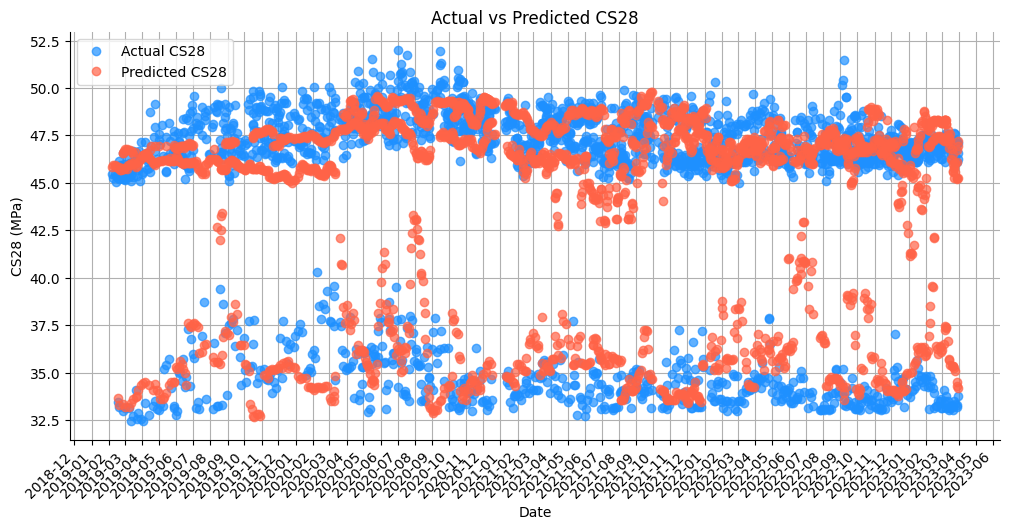

<IPython.core.display.Javascript object>

In [109]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(12, 6))
plt.plot(
    test_data["DATE"],
    test_data["CS28"],
    color="dodgerblue",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Actual CS28",
)
plt.plot(
    test_data["DATE"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Predicted CS28",
)
plt.xlabel("Date")
plt.ylabel("CS28 (MPa)")
plt.title("Actual vs Predicted CS28")
plt.legend()
plt.grid(True)

# Improving x-axis readability
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Set ticks for each month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format date as 'YYYY-MM-DD'
plt.gcf().autofmt_xdate(rotation=45)  # Rotate x-axis labels

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "ecics_203_c_local_cm_btiss_dominant_top_two_pred_vs_actual_cs28_over_time.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


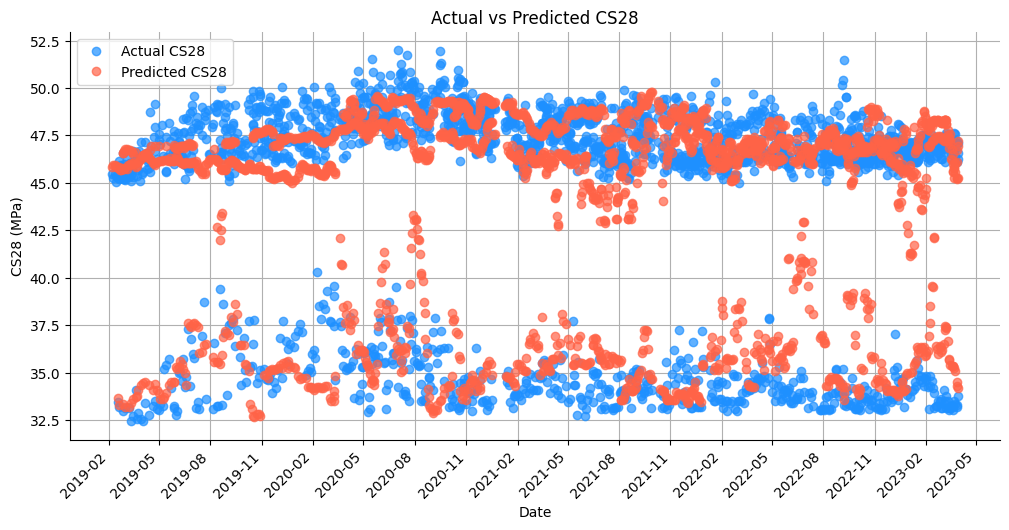

<IPython.core.display.Javascript object>

In [110]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(12, 6))
plt.plot(
    test_data["DATE"],
    test_data["CS28"],
    color="dodgerblue",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Actual CS28",
)
plt.plot(
    test_data["DATE"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Predicted CS28",
)
plt.xlabel("Date")
plt.ylabel("CS28 (MPa)")
plt.title("Actual vs Predicted CS28")
plt.legend()
plt.grid(True)

# Improving x-axis readability
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Display every 3rd month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format date as 'YYYY-MM-DD'
plt.gcf().autofmt_xdate(rotation=45)  # Rotate x-axis labels

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "ecics_203_c_local_cm_btiss_dominant_top_two_pred_vs_actual_cs28_over_time.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


# Feature Importance

In [111]:
def permutation_importance_seq(model, X, y, metric, n_repeats=5):
    """
    Computes permutation importance for sequence models with 3D input.
    """
    baseline_score = metric(y, model.predict(X))
    num_features = X.shape[2]  # Number of features
    importances = np.zeros(num_features)
    set_seeds()
    for i in range(num_features):
        scores = []
        for _ in range(n_repeats):
            X_permuted = X.copy()
            # Shuffle feature i across samples, keeping time steps intact
            for t in range(X.shape[1]):
                # Extract the feature values at time t
                feature_values = X_permuted[:, t, i]
                np.random.shuffle(feature_values)
                X_permuted[:, t, i] = feature_values
            # Compute metric with permuted data
            permuted_score = metric(y, model.predict(X_permuted, verbose=0))
            scores.append(permuted_score)
        # Importance is the increase in metric when the feature is permuted
        importances[i] = baseline_score - np.mean(scores)
    return importances

<IPython.core.display.Javascript object>

In [112]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from tqdm import tqdm

feature_importances = []

for idx, (imputer, scaler, estimator) in tqdm(enumerate(pipelines_final)):
    train_index = indices_final["train"][idx]
    x_train = x.iloc[train_index].reset_index(drop=True)
    y_train = y.iloc[train_index].reset_index(drop=True)

    test_index = indices_final["test"][idx]
    x_test = x.iloc[test_index].reset_index(drop=True)
    y_test = y.iloc[test_index].reset_index(drop=True)

    # Preprocess x_test
    x_test_imputed = imputer.transform(x_test)
    x_test_scaled = scaler.transform(x_test_imputed)

    # Generate sequences
    dataset = {
        "x_train": x_test_scaled,
        "y_train": y_test,
        "x_test": x_test_scaled,
        "y_test": y_test,
    }
    dataset = generate_sequences(
        dataset, params["timesteps"], split_by_cement_type=False
    )
    x_test_seq = dataset["x_test"]
    y_test_seq = dataset["y_test"]

    # Compute permutation importance
    importances = permutation_importance_seq(
        estimator, x_test_seq, y_test_seq, r2_score, n_repeats=10
    )
    feature_importances.append(importances)

0it [00:00, ?it/s]

15/15 [==============================] - 0s 4ms/step


1it [00:13, 13.27s/it]

15/15 [==============================] - 0s 4ms/step


2it [00:27, 13.79s/it]

15/15 [==============================] - 0s 4ms/step


3it [00:41, 14.01s/it]

15/15 [==============================] - 0s 4ms/step


4it [00:56, 14.13s/it]

15/15 [==============================] - 0s 4ms/step


5it [01:10, 14.21s/it]

15/15 [==============================] - 0s 4ms/step


6it [01:24, 14.20s/it]

15/15 [==============================] - 0s 4ms/step


7it [01:38, 14.19s/it]

15/15 [==============================] - 0s 4ms/step


8it [01:52, 14.18s/it]

15/15 [==============================] - 0s 4ms/step


9it [02:07, 14.31s/it]

15/15 [==============================] - 0s 4ms/step


10it [02:21, 14.19s/it]

15/15 [==============================] - 0s 3ms/step


11it [02:35, 14.17s/it]

15/15 [==============================] - 0s 4ms/step


12it [02:49, 14.25s/it]

15/15 [==============================] - 0s 4ms/step


13it [03:04, 14.21s/it]

15/15 [==============================] - 0s 4ms/step


14it [03:18, 14.20s/it]

15/15 [==============================] - 0s 4ms/step


15it [03:31, 14.12s/it]


<IPython.core.display.Javascript object>

In [113]:
import numpy as np
import pandas as pd

# Average importances across folds
mean_importances = np.mean(feature_importances, axis=0)

# importances_df = pd.DataFrame(feature_importances, columns=x.columns)
# Transpose the list of arrays so that each row corresponds to a permutation/model, and each column to a feature
importances_df = pd.DataFrame(feature_importances)

# Assign the feature names to the columns
importances_df.columns = x.columns

# Map importances to feature names
importances_df_mean = (
    importances_df.mean(axis=0)
    .to_frame()
    .reset_index(0)
    .rename({"index": "Feature", 0: "Importance"}, axis=1)
)

<IPython.core.display.Javascript object>

In [114]:
rename_dict = {
    "K2O": r"$\mathrm{K_2O}$",
    "Free CaO": r"Free $\mathrm{CaO}$",
    "Total C2S": r"Total $\mathrm{C_2S}$",
    "Na2O": r"$\mathrm{Na_2O}$",
    "CaO": r"$\mathrm{CaO}$",
    "SiO2": r"$\mathrm{SiO_2}$",
    "MgO": r"$\mathrm{MgO}$",
    "Fe2O3": r"$\mathrm{Fe_2O_3}$",
    "Al2O3": r"$\mathrm{Al_2O_3}$",
    "Total C3S": r"Total $\mathrm{C_3S}$",
    "C3A": r"$\mathrm{C_3A}$",
    "C4AF": r"$\mathrm{C_4AF}$",
    "LOI": "LOI",
    "SO3": r"$\mathrm{SO_3}$",
    "Insoluble Residue": "IR",
}

importances_df = importances_df.rename(rename_dict, axis=1)
importances_df_mean["Feature"] = importances_df_mean["Feature"].replace(rename_dict)

<IPython.core.display.Javascript object>

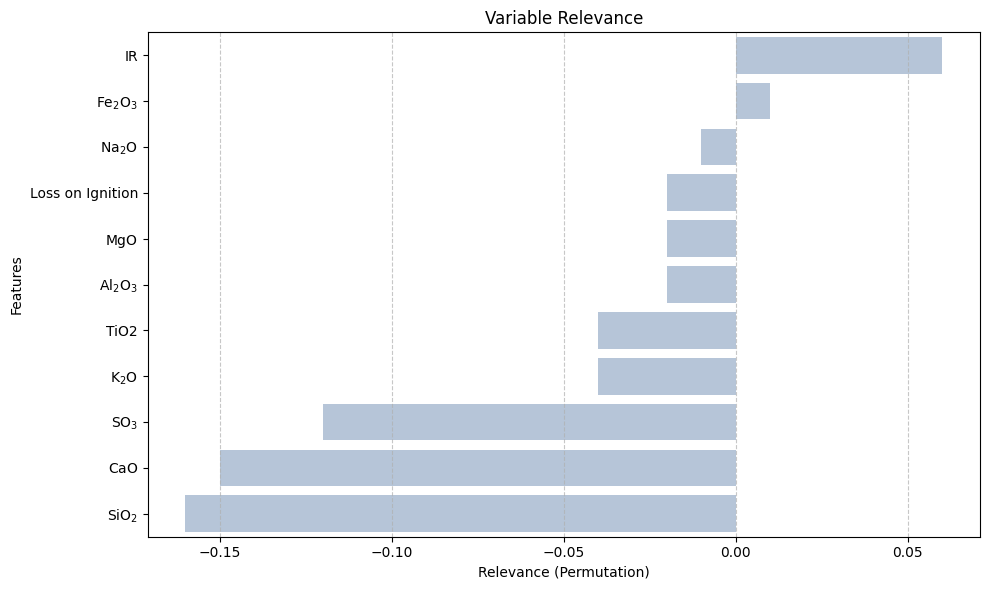

<IPython.core.display.Javascript object>

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort importances
mean_importances_df = importances_df_mean.sort_values(
    by="Importance", ascending=False
).round(2)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x="Importance", y="Feature", data=mean_importances_df, color="lightsteelblue"
)
plt.title("Variable Relevance")
plt.xlabel("Relevance (Permutation)")
plt.ylabel("Features")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
# plt.savefig(
#     "variable_relevance.png",
#     dpi=300,
#     bbox_inches="tight",
# )
plt.show()

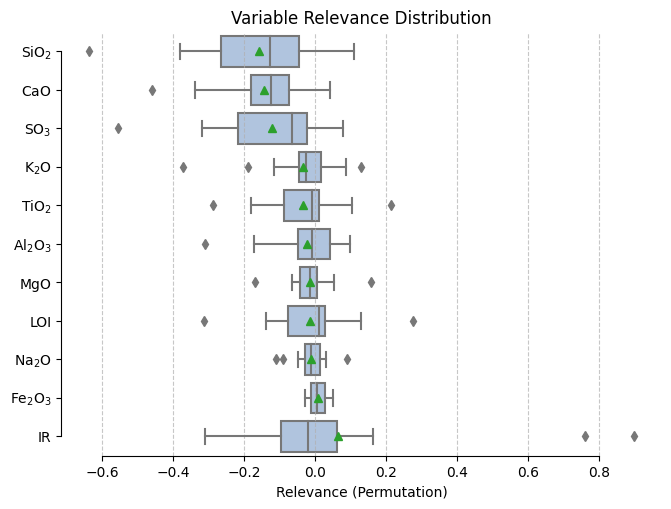

<IPython.core.display.Javascript object>

In [116]:
perm_importances_df = importances_df


# Calculate the mean importance for each feature
mean_importances = perm_importances_df.mean().sort_values()

# Reorder the DataFrame columns based on mean importance
perm_importances_df = perm_importances_df[mean_importances.index]


# Backup the original backend
original_backend = plt.get_backend()

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)

# Convert chemical formulas using MathText syntax
perm_importances_df_plot = perm_importances_df.rename(
    columns={
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
        "Loss on Ignition": "LOI",
        "TiO2": r"$\mathrm{TiO_2}$",
    }
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=perm_importances_df_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Relevance (Permutation)")
plt.title("Variable Relevance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_203_c_local_cm_btiss_transformer_dominant_top_two_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)


# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

plt.show()

In [117]:
perm_importances_df.describe().T

,count,mean,std,min,25%,50%,75%,max
$\mathrm{SiO_2}$,15.0,-0.157676,0.194232,-0.638897,-0.266448,-0.128489,-0.047549,0.107671
$\mathrm{CaO}$,15.0,-0.145866,0.133783,-0.459797,-0.181080,-0.124061,-0.075527,0.041309
$\mathrm{SO_3}$,15.0,-0.121880,0.165683,-0.555499,-0.219019,-0.065923,-0.023088,0.077556
$\mathrm{K_2O}$,15.0,-0.035936,0.121607,-0.373312,-0.046848,-0.026240,0.014989,0.128046
TiO2,15.0,-0.035056,0.118850,-0.287311,-0.089293,-0.010587,0.011091,0.213249
$\mathrm{Al_2O_3}$,15.0,-0.023297,0.105591,-0.310302,-0.048601,-0.008568,0.041305,0.098673
$\mathrm{MgO}$,15.0,-0.016019,0.068874,-0.169208,-0.044361,-0.015216,0.004251,0.158042
Loss on Ignition,15.0,-0.015925,0.130601,-0.312827,-0.077222,0.010619,0.026445,0.275918
$\mathrm{Na_2O}$,15.0,-0.012067,0.049170,-0.112372,-0.029128,-0.011578,0.012255,0.089850
$\mathrm{Fe_2O_3}$,15.0,0.007689,0.026378,-0.030525,-0.011892,0.004259,0.028316,0.050889


<IPython.core.display.Javascript object>